In [1]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks
from IPython.display import HTML
from tqdm import tqdm
import pickle
import matplotlib.cm as cm

import visualisation as vis
from delta_hes_model import *
from analysis import *

plt.rcParams['text.usetex'] = True

hescolor1 = '#fdc776'  # light
hescolor2 = '#fc4e2a'  # dark
hescolor3 = '#8b1a0e'  # dark red with a warm tone

# Two coupled cell results module

This Jupyter Notebook file runs simulations for different variations of parameters. $p_d$, $n$, $\gamma_d$, $\tau_d$ and $\tau_h$.
Also gives the option to load pre-run simulation results to save time. 

And then analyses this data in multiple sections. Structured like subsections of the thesis chapter on two cell results. 
- Results for heterogeneity
- Results for synchronised oscillatory behaviour
- Results for coupling delay
- Results for different initial values of checkerboard initialisation

In [2]:
#set the lattice of the cells 
P = 2
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50
T_h = 0
T_coupling = 0
w_h = 1
w_coupling = 0.02
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

num_tsteps = 40000
dt = 0.2

# Obtain data and save in files

In [ ]:
epsilons = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
p_ds = [10, 20, 50, 100, 150, 200]
hill_coeffs = [1, 2, 3, 4, 5]
gamma_ds = [0.01, 0.02, 0.03, 0.04, 0.05]
delays = [0, 1, 2, 5, 10, 20, 30, 40, 50, 60, 70]

# runs with no hes oscillations
results_pd_uni = np.zeros((len(p_ds), len(epsilons), num_tsteps, 3, 2))
results_n_uni = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps, 3, 2))
results_gamma_uni = np.zeros((len(gamma_ds), len(epsilons), num_tsteps, 3, 2))
results_pd_checkerboard = np.zeros((len(p_ds), len(epsilons), num_tsteps, 3, 2))
results_n_checkerboard = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps, 3, 2))
results_gamma_checkerboard = np.zeros((len(gamma_ds), len(epsilons), num_tsteps, 3, 2))
results_delay_uniform = np.zeros((len(delays), len(epsilons), num_tsteps, 3, 2))


# runs with hes oscillations
results_pd_hes_uni = np.zeros((len(p_ds), len(epsilons), num_tsteps, 3, 2))
results_n_hes_uni = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps, 3, 2))
results_gamma_hes_uni = np.zeros((len(gamma_ds), len(epsilons), num_tsteps, 3, 2))
results_pd_hes_checkerboard = np.zeros((len(p_ds), len(epsilons), num_tsteps, 3, 2))
results_n_hes_checkerboard = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps, 3, 2))
results_gamma_hes_checkerboard = np.zeros((len(gamma_ds), len(epsilons), num_tsteps, 3, 2))
results_delay_hes_uniform = np.zeros((len(delays), len(epsilons), num_tsteps, 3, 2))

# run simulations for different p_d values
for i, p_d in enumerate(p_ds):
    for j, epsilon in enumerate(epsilons):
        # set the parameters for the simulation with no hes oscillations
        gamma_d = 0.03
        T_coupling = 0 
        n = 3
        T_h = 0
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_pd_uni[i,j,:,0,0], results_pd_uni[i,j,:,0,1], results_pd_uni[i,j,:,1,0], results_pd_uni[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_pd_uni[i,j,:,2,0], results_pd_uni[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)
        results_pd_checkerboard[i,j,:,0,0], results_pd_checkerboard[i,j,:,0,1], results_pd_checkerboard[i,j,:,1,0], results_pd_checkerboard[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_pd_checkerboard[i,j,:,2,0], results_pd_checkerboard[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()
        # results_pd_checkerboard[i,j,:,0,0], results_pd_checkerboard[i,j,:,0,1], results_pd_checkerboard[i,j,:,1,0], results_pd_checkerboard[i,j,:,1,1] = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)

        #set the hes oscillations
        T_h = 20
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_pd_hes_uni[i,j,:,0,0], results_pd_hes_uni[i,j,:,0,1], results_pd_hes_uni[i,j,:,1,0], results_pd_hes_uni[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_pd_hes_uni[i,j,:,2,0], results_pd_hes_uni[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)
        results_pd_hes_checkerboard[i,j,:,0,0], results_pd_hes_checkerboard[i,j,:,0,1], results_pd_hes_checkerboard[i,j,:,1,0], results_pd_hes_checkerboard[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_pd_hes_checkerboard[i,j,:,2,0], results_pd_hes_checkerboard[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

# run simulations for different hill coefficients
for i, n in enumerate(hill_coeffs):
    for j, epsilon in enumerate(epsilons):
        # set the parameters for the simulation with no hes oscillations
        gamma_d = 0.03
        T_coupling = 0 
        p_d = 50
        T_h = 0
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_n_uni[i,j,:,0,0], results_n_uni[i,j,:,0,1], results_n_uni[i,j,:,1,0], results_n_uni[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_n_uni[i,j,:,2,0], results_n_uni[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)
        results_n_checkerboard[i,j,:,0,0], results_n_checkerboard[i,j,:,0,1], results_n_checkerboard[i,j,:,1,0], results_n_checkerboard[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_n_checkerboard[i,j,:,2,0], results_n_checkerboard[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()
        #set the hes oscillations
        T_h = 20
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_n_hes_uni[i,j,:,0,0], results_n_hes_uni[i,j,:,0,1], results_n_hes_uni[i,j,:,1,0], results_n_hes_uni[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_n_hes_uni[i,j,:,2,0], results_n_hes_uni[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)
        results_n_hes_checkerboard[i,j,:,0,0], results_n_hes_checkerboard[i,j,:,0,1], results_n_hes_checkerboard[i,j,:,1,0], results_n_hes_checkerboard[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_n_hes_checkerboard[i,j,:,2,0], results_n_hes_checkerboard[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

# run simulations for different gamma_d values
for i, gamma_d in enumerate(gamma_ds):
    for j, epsilon in enumerate(epsilons):
        # set the parameters for the simulation with no hes oscillations
        T_coupling = 0 
        p_d = 50
        n = 3
        T_h = 0
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_gamma_uni[i,j,:,0,0], results_gamma_uni[i,j,:,0,1], results_gamma_uni[i,j,:,1,0], results_gamma_uni[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_gamma_uni[i,j,:,2,0], results_gamma_uni[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)
        results_gamma_checkerboard[i,j,:,0,0], results_gamma_checkerboard[i,j,:,0,1], results_gamma_checkerboard[i,j,:,1,0], results_gamma_checkerboard[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_gamma_checkerboard[i,j,:,2,0], results_gamma_checkerboard[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

        #set the hes oscillations
        T_h = 20
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_gamma_hes_uni[i,j,:,0,0], results_gamma_hes_uni[i,j,:,0,1], results_gamma_hes_uni[i,j,:,1,0], results_gamma_hes_uni[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_gamma_hes_uni[i,j,:,2,0], results_gamma_hes_uni[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)
        results_gamma_hes_checkerboard[i,j,:,0,0], results_gamma_hes_checkerboard[i,j,:,0,1], results_gamma_hes_checkerboard[i,j,:,1,0], results_gamma_hes_checkerboard[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_gamma_hes_checkerboard[i,j,:,2,0], results_gamma_hes_checkerboard[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

# run simulations for different delays
for i, T_coupling in enumerate(delays):
    for j, epsilon in enumerate(epsilons):
        # set the parameters for the simulation with no hes oscillations
        gamma_d = 0.03
        p_d = 50
        n = 3
        T_h = 0
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_delay_uniform[i,j,:,0,0], results_delay_uniform[i,j,:,0,1], results_delay_uniform[i,j,:,1,0], results_delay_uniform[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_delay_uniform[i,j,:,2,0], results_delay_uniform[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

        T_h = 20 
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_delay_hes_uniform[i,j,:,0,0], results_delay_hes_uniform[i,j,:,0,1], results_delay_hes_uniform[i,j,:,1,0], results_delay_hes_uniform[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_delay_hes_uniform[i,j,:,2,0], results_delay_hes_uniform[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

# Uncomment the following lines to save the results
# with open('results_pd_uni.pickle', 'wb') as f:
#     pickle.dump(results_pd_uni, f)
# with open('results_n_uni.pickle', 'wb') as f:
#     pickle.dump(results_n_uni, f)
# with open('results_gamma_uni.pickle', 'wb') as f:
#     pickle.dump(results_gamma_uni, f)
# with open('results_pd_checkerboard.pickle', 'wb') as f:
#     pickle.dump(results_pd_checkerboard, f)
# with open('results_n_checkerboard.pickle', 'wb') as f:
#     pickle.dump(results_n_checkerboard, f)
# with open('results_gamma_checkerboard.pickle', 'wb') as f:
#     pickle.dump(results_gamma_checkerboard, f)
# with open('results_pd_hes_uni.pickle', 'wb') as f:
#     pickle.dump(results_pd_hes_uni, f)
# with open('results_n_hes_uni.pickle', 'wb') as f:
#     pickle.dump(results_n_hes_uni, f)
# with open('results_gamma_hes_uni.pickle', 'wb') as f:
#     pickle.dump(results_gamma_hes_uni, f)
# with open('results_pd_hes_checkerboard.pickle', 'wb') as f:
#     pickle.dump(results_pd_hes_checkerboard, f)
# with open('results_n_hes_checkerboard.pickle', 'wb') as f:
#     pickle.dump(results_n_hes_checkerboard, f)
# with open('results_gamma_hes_checkerboard.pickle', 'wb') as f:
#     pickle.dump(results_gamma_hes_checkerboard, f)
# with open('results_delay_uniform.pickle', 'wb') as f:
#     pickle.dump(results_delay_uniform, f)
# with open('results_delay_hes_uniform.pickle', 'wb') as f:
#     pickle.dump(results_delay_hes_uniform, f)



100%|██████████| 39999/39999 [00:06<00:00, 6474.43it/s]


In [ ]:
initial_values_small = np.linspace(98.5, 100, 10)
initial_values = [0, 25, 50, 75]
initial_values.extend(initial_values_small)
initial_values.extend([105, 110, 115, 120])
coupling_strength = 0.25

# set initial parameters of the reactions 
gamma_d = 0.03
p_h = 100
T_h = 20
T_coupling = 0
w_coupling = 0.25
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

num_tsteps = 40000
dt = 0.2

results_25 = np.zeros((len(initial_values), num_tsteps, 3, 2))

# run simulations for different initial values with coupling strength 0.25
for i, initial in enumerate(initial_values):

        # set the parameters for the simulation with no hes oscillations
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, coupling_strength, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        # run the simulation with the initial value
        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=initial)
        results_25[i, :, 0, 0], results_25[i, :, 0, 1], results_25[i, :, 1, 0],results_25[i, :, 1, 1], results_25[i, :, 2, 0], results_25[i, :, 2,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten(), m_h[:,0].flatten(), m_h[:,1].flatten()

with open('results_25.pkl', 'wb') as f:
    pickle.dump(results_25, f)
    
initial_values_range = np.linspace(80, 110, 16)
coupling_strength_range = np.linspace(0, 1, 21)

results_initial_heatmap = np.zeros((len(initial_values_range), len(coupling_strength_range), num_tsteps, 3, 2))
for i, initial in enumerate(initial_values_range):
    for j, coupling_strength in enumerate(coupling_strength_range):
        # set the parameters for the simulation with no hes oscillations
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, coupling_strength, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        # run the simulation with the initial value
        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=initial)
        results_initial_heatmap[i,j,:,0,0], results_initial_heatmap[i,j,:,0,1], results_initial_heatmap[i,j,:,1,0], results_initial_heatmap[i,j,:,1,1], results_initial_heatmap[i,j,:,2,0], results_initial_heatmap[i,j,:,2,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten(), m_h[:,0].flatten(), m_h[:,1].flatten() 

with open('results_initial_heatmap.pkl', 'wb') as f:
    pickle.dump(results_initial_heatmap, f)

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([20., 20.]), T_coupling=array([0., 0.]), w_h=1, w_coupling=0.25, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0.2, grad_coup_strength=0)
Running simulation for initial value 0 and coupling strength 0.25


100%|██████████| 39999/39999 [00:06<00:00, 6457.69it/s]


Running simulation for initial value 25 and coupling strength 0.25


100%|██████████| 39999/39999 [00:05<00:00, 6844.06it/s]


Running simulation for initial value 50 and coupling strength 0.25


100%|██████████| 39999/39999 [00:05<00:00, 6983.30it/s]


Running simulation for initial value 75 and coupling strength 0.25


100%|██████████| 39999/39999 [00:05<00:00, 7470.32it/s]


Running simulation for initial value 98.5 and coupling strength 0.25


100%|██████████| 39999/39999 [00:05<00:00, 6755.83it/s]


Running simulation for initial value 98.66666666666667 and coupling strength 0.25


100%|██████████| 39999/39999 [00:05<00:00, 7092.78it/s]


Running simulation for initial value 98.83333333333333 and coupling strength 0.25


100%|██████████| 39999/39999 [00:05<00:00, 7245.65it/s]


Running simulation for initial value 99.0 and coupling strength 0.25


100%|██████████| 39999/39999 [00:05<00:00, 6981.00it/s]


Running simulation for initial value 99.16666666666667 and coupling strength 0.25


100%|██████████| 39999/39999 [00:05<00:00, 7174.13it/s]


Running simulation for initial value 99.33333333333333 and coupling strength 0.25


100%|██████████| 39999/39999 [00:06<00:00, 6153.37it/s]


Running simulation for initial value 99.5 and coupling strength 0.25


100%|██████████| 39999/39999 [00:06<00:00, 6089.85it/s]


Running simulation for initial value 99.66666666666667 and coupling strength 0.25


100%|██████████| 39999/39999 [00:06<00:00, 6179.61it/s]


Running simulation for initial value 99.83333333333333 and coupling strength 0.25


100%|██████████| 39999/39999 [00:06<00:00, 5746.75it/s]


Running simulation for initial value 100.0 and coupling strength 0.25


100%|██████████| 39999/39999 [00:06<00:00, 6494.65it/s]


Running simulation for initial value 105 and coupling strength 0.25


100%|██████████| 39999/39999 [00:05<00:00, 7180.28it/s]


Running simulation for initial value 110 and coupling strength 0.25


100%|██████████| 39999/39999 [00:05<00:00, 7155.97it/s]


Running simulation for initial value 115 and coupling strength 0.25


100%|██████████| 39999/39999 [00:06<00:00, 6014.17it/s]


Running simulation for initial value 120 and coupling strength 0.25


100%|██████████| 39999/39999 [00:06<00:00, 6650.71it/s]


In [ ]:
epsilons = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
delays = [0, 1, 2, 5, 10, 20, 30, 40, 50, 60, 70]

num_tsteps = 40000
results_delay_uniform = np.zeros((len(delays), len(epsilons), num_tsteps, 3, 2))
results_delay_hes_uniform = np.zeros((len(delays), len(epsilons), num_tsteps, 3, 2))

for i, T_coupling in enumerate(delays):
    for j, epsilon in enumerate(epsilons):
        # set the parameters for the simulation with no hes oscillations
        gamma_d = 0.03
        p_d = 50
        n = 3
        T_h = 0
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_delay_uniform[i,j,:,0,0], results_delay_uniform[i,j,:,0,1], results_delay_uniform[i,j,:,1,0], results_delay_uniform[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_delay_uniform[i,j,:,2,0], results_delay_uniform[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

        T_h = 20 
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_delay_hes_uniform[i,j,:,0,0], results_delay_hes_uniform[i,j,:,0,1], results_delay_hes_uniform[i,j,:,1,0], results_delay_hes_uniform[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        results_delay_hes_uniform[i,j,:,2,0], results_delay_hes_uniform[i,j,:,2,1] = m_h[:,0].flatten(), m_h[:,1].flatten()

with open('results_delay_uniform.pickle', 'wb') as f:
    pickle.dump(results_delay_uniform, f)
with open('results_delay_hes_uniform.pickle', 'wb') as f:
    pickle.dump(results_delay_hes_uniform, f)

100%|██████████| 39999/39999 [00:05<00:00, 7110.79it/s]


# Load data from files

In [3]:
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_pd_uni.pickle', 'rb') as f:
    results_pd_uni = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_n_uni.pickle', 'rb') as f:
    results_n_uni = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_gamma_uni.pickle', 'rb') as f:
    results_gamma_uni = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_pd_checkerboard.pickle', 'rb') as f:
    results_pd_checkerboard = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_n_checkerboard.pickle', 'rb') as f:
    results_n_checkerboard = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_gamma_checkerboard.pickle', 'rb') as f:
    results_gamma_checkerboard = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_pd_hes_uni.pickle', 'rb') as f:
    results_pd_hes_uni = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_n_hes_uni.pickle', 'rb') as f:
    results_n_hes_uni = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_gamma_hes_uni.pickle', 'rb') as f:
    results_gamma_hes_uni = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_pd_hes_checkerboard.pickle', 'rb') as f:
    results_pd_hes_checkerboard = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_n_hes_checkerboard.pickle', 'rb') as f:
    results_n_hes_checkerboard = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_gamma_hes_checkerboard.pickle', 'rb') as f:
    results_gamma_hes_checkerboard = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_delay_uniform.pickle', 'rb') as f:
    results_delay_uniform = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_delay_hes_uniform.pickle', 'rb') as f:
    results_delay_hes_uniform = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_initial_heatmap.pkl', 'rb') as f:
    results_initial_heatmap = pickle.load(f)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_25.pkl', 'rb') as f:
    results_25 = pickle.load(f)

epsilons = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
p_ds = [10, 20, 50, 100, 150, 200]
hill_coeffs = [1, 2, 3, 4, 5]
delays = [0, 1, 2, 5, 10, 20, 30, 40, 50, 60, 70]
gamma_ds = [0.01, 0.02, 0.03, 0.04, 0.05]
initial_values_range = np.linspace(80, 110, 16)
coupling_strength_range = np.linspace(0, 1, 21)

initial_values_small = np.linspace(98.5, 100, 10)
initial_values = [0, 25, 50, 75]
initial_values.extend(initial_values_small)
initial_values.extend([105, 110, 115, 120])

num_tsteps = 40000
dt = 0.2

# Calculate all results

In [4]:
# set time point for the analysis
time_settled = 2000
time_checkerboard = 8000

# calculate results for the no hes delay results
result_diff_pd, result_diff_LI_mean_pd, result_LI_mean_pd, result_synced_index_pd, result_period_synced_pd, result_amplitude_synced_pd, result_period_LI_pd, result_amplitude_LI_pd = analysis_2cells(results_pd_uni, time_settled, p_ds, epsilons)
result_diff_pd_check,  mean_diff_pd_check, result_period_pd_check, result_amplitude_pd_check = analysis_2cells_checkerboard(results_pd_checkerboard, time_checkerboard, p_ds, epsilons)
result_diff_n, result_diff_LI_mean_n, result_LI_mean_n, result_synced_index_n, result_period_synced_n, result_amplitude_synced_n, result_period_LI_n, result_amplitude_LI_n = analysis_2cells(results_n_uni, time_settled, hill_coeffs, epsilons)
result_diff_n_check,  mean_diff_n_check, result_period_n_check, result_amplitude_n_check = analysis_2cells_checkerboard(results_n_checkerboard, time_checkerboard, hill_coeffs, epsilons)
result_diff_gamma, result_diff_LI_mean_gamma, result_LI_mean_gamma, result_synced_index_gamma, result_period_synced_gamma, result_amplitude_synced_gamma, result_period_LI_gamma, result_amplitude_LI_gamma = analysis_2cells(results_gamma_uni, time_settled, gamma_ds, epsilons)
result_diff_gamma_check, mean_diff_gamma_check, result_period_gamma_check, result_amplitude_gamma_check = analysis_2cells_checkerboard(results_gamma_checkerboard, time_checkerboard, gamma_ds, epsilons)
# result_diff_gamma_check, result_diff_LI_mean_gamma_check, result_LI_mean_gamma_check, result_synced_index_gamma_check, result_period_synced_gamma_check, result_amplitude_synced_gamma_check, result_period_LI_gamma_check, result_amplitude_LI_gamma_check = analysis_2cells(results_gamma_checkerboard, time_settled, gamma_ds, epsilons)

# calculate results for the with hes delay results
result_diff_pd_hes, result_diff_LI_mean_pd_hes, result_LI_mean_pd_hes, result_synced_index_pd_hes, result_period_synced_pd_hes, result_amplitude_synced_pd_hes, result_period_LI_pd_hes, result_amplitude_LI_pd_hes = analysis_2cells(results_pd_hes_uni, time_settled, p_ds, epsilons)
result_diff_pd_hes_check,  mean_diff_pd_hes_check, result_period_pd_hes_check, result_amplitude_pd_hes_check = analysis_2cells_checkerboard(results_pd_hes_checkerboard, time_checkerboard, p_ds, epsilons)
result_diff_n_hes, result_diff_LI_mean_n_hes, result_LI_mean_n_hes, result_synced_index_n_hes, result_period_synced_n_hes, result_amplitude_synced_n_hes, result_period_LI_n_hes, result_amplitude_LI_n_hes = analysis_2cells(results_n_hes_uni, time_settled, hill_coeffs, epsilons)
result_diff_n_hes_check,  mean_diff_n_hes_check, result_period_n_hes_check, result_amplitude_n_hes_check = analysis_2cells_checkerboard(results_n_hes_checkerboard, time_checkerboard, hill_coeffs, epsilons)
# result_diff_n_hes_check, result_diff_LI_mean_n_hes_check, result_LI_mean_n_hes_check, result_synced_index_n_hes_check, result_period_synced_n_hes_check, result_amplitude_synced_n_hes_check, result_period_LI_n_hes_check, result_amplitude_LI_n_hes_check = analysis_2cells(results_n_hes_checkerboard, time_settled, hill_coeffs, epsilons)
result_diff_gamma_hes, result_diff_LI_mean_gamma_hes, result_LI_mean_gamma_hes, result_synced_index_gamma_hes, result_period_synced_gamma_hes, result_amplitude_synced_gamma_hes, result_period_LI_gamma_hes, result_amplitude_LI_gamma_hes = analysis_2cells(results_gamma_hes_uni, time_settled, gamma_ds, epsilons)
result_diff_gamma_hes_check, mean_diff_gamma_hes_check, result_period_gamma_hes_check, result_amplitude_gamma_hes_check = analysis_2cells_checkerboard(results_gamma_hes_checkerboard, time_checkerboard, gamma_ds, epsilons)
# result_diff_gamma_hes_check, result_diff_LI_mean_gamma_hes_check, result_LI_mean_gamma_hes_check, result_synced_index_gamma_hes_check, result_period_synced_gamma_hes_check, result_amplitude_synced_gamma_hes_check, result_period_LI_gamma_hes_check, result_amplitude_LI_gamma_hes_check = analysis_2cells(results_gamma_hes_checkerboard, time_settled, gamma_ds, epsilons)

# calculate results for the delay results
result_diff_delay, result_synced_index_delay, result_period_synced_delay, result_amplitude_synced_delay, result_shift_delay = analysis_2cells_delay(results_delay_uniform, time_settled, delays, epsilons)
result_diff_delay_hes, result_synced_index_delay_hes, result_period_synced_delay_hes, result_amplitude_synced_delay_hes, result_shift_delay_hes = analysis_2cells_delay(results_delay_hes_uniform, time_settled, delays, epsilons)

In [ ]:
# Save data for periods of two cell system for standard parameters to a comparison file for 1D array analysis
np.savez('comparison-two-cell.npz', epsilons=epsilons, periods=result_period_synced_pd_hes[0][2,:])

# Results for heterogeneity

from checkerboard initialisation because that is either homogeneous fixed state or goes into LI very quickly 

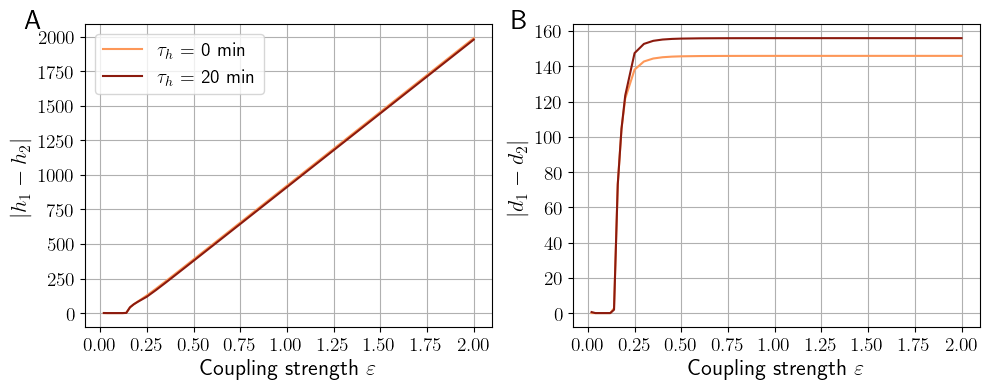

In [5]:
colours = vis.get_hes_colors(len(p_ds))
letters = ["A", "B"]
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(epsilons[:-4], mean_diff_pd_check[0][2,:-4], color=colours[1], label=fr'$\tau_h$ = 0 min')
plt.plot(epsilons[:-4], mean_diff_pd_hes_check[0][2,:-4],color= colours[-1], label=fr'$\tau_h$ = 20 min')
plt.xlabel(r'Coupling strength $\varepsilon$', fontsize=16)
plt.ylabel(r'$|h_1 - h_2|$', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
ax = plt.gca()
ax.text(-0.15, 1.05, letters[0], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top')

plt.subplot(1,2,2)
plt.plot(epsilons[:-4], mean_diff_pd_check[2][2,:-4], color=colours[1], label=fr'$\tau_h$ = 0 min')
plt.plot(epsilons[:-4], mean_diff_pd_hes_check[2][2,:-4], color=colours[-1], label=fr'$\tau_h$ = 20 min')
plt.xlabel(r'Coupling strength $\varepsilon$', fontsize=16)
plt.ylabel(r'$|d_1 - d_2|$', fontsize=16)
# plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
ax = plt.gca()
ax.text(-0.15, 1.05, letters[1], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top')
plt.tight_layout()

# plt.savefig('two-cell-mean-diff-lat-inhib.png', dpi=300, bbox_inches='tight')

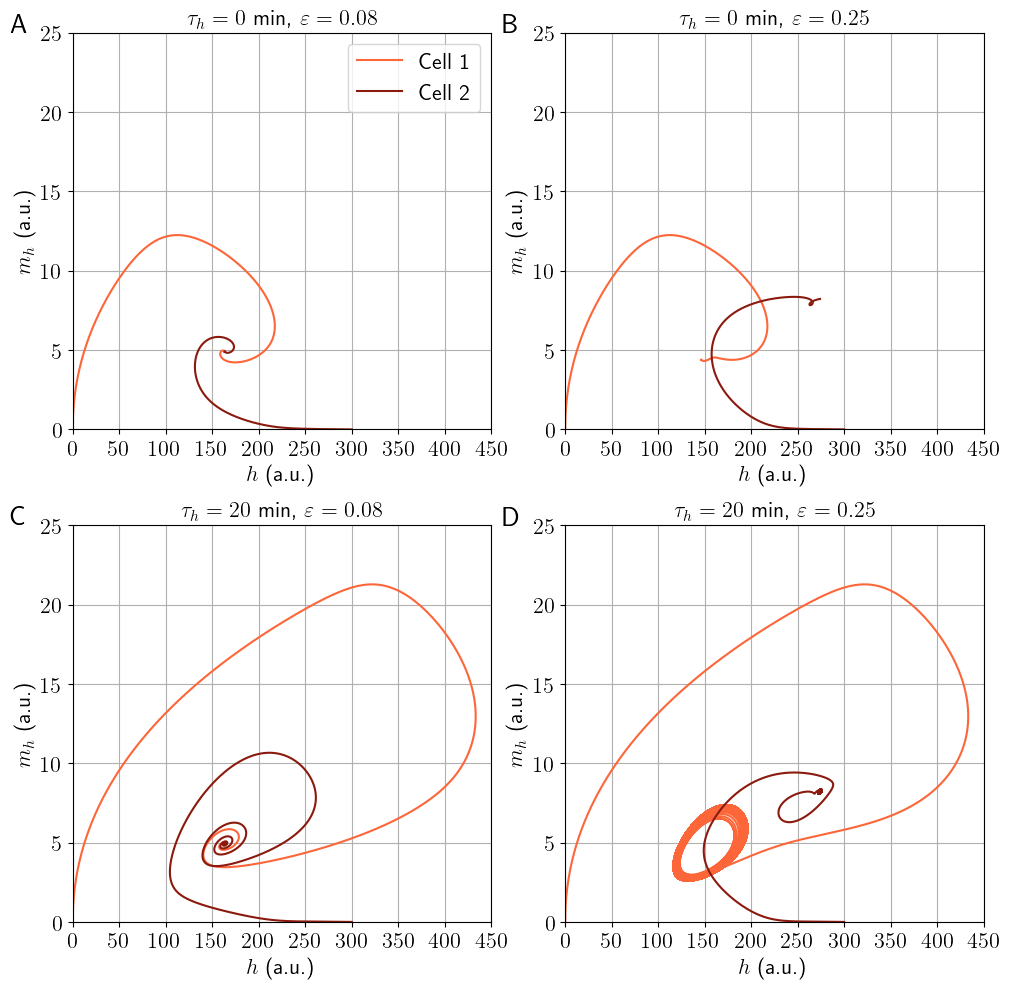

In [8]:
low_epsilon = 3
high_epsilon = 10

letters = ["A", "B", "C", "D"]

plt.figure(figsize=(10, 10))

# --- Subplot 1 ---
plt.subplot(2, 2, 1)
plt.plot(results_pd_checkerboard[2, low_epsilon, :, 0, 0],
         results_pd_checkerboard[2, low_epsilon, :, 2, 0],
         label='Cell 1', color=colours[2])
plt.plot(results_pd_checkerboard[2, low_epsilon, :, 0, 1],
         results_pd_checkerboard[2, low_epsilon, :, 2, 1],
         label='Cell 2', color=colours[-1])
plt.xlabel(r'$h$ (a.u.)', fontsize=16)
plt.ylabel(r'$m_h$ (a.u.)', fontsize=16)
plt.title(rf'$\tau_h = 0$ min, $\varepsilon = {epsilons[low_epsilon]}$', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 450)
plt.ylim(0, 25)
plt.grid()
ax = plt.gca()
ax.text(-0.15, 1.05, letters[0], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top')

# --- Subplot 2 ---
plt.subplot(2, 2, 2)
plt.plot(results_pd_checkerboard[2, high_epsilon, :, 0, 0],
         results_pd_checkerboard[2, high_epsilon, :, 2, 0],
         label='Cell 1', color=colours[2])
plt.plot(results_pd_checkerboard[2, high_epsilon, :, 0, 1],
         results_pd_checkerboard[2, high_epsilon, :, 2, 1],
         label='Cell 2', color=colours[-1])
plt.xlabel(r'$h$ (a.u.)', fontsize=16)
plt.ylabel(r'$m_h$ (a.u.)', fontsize=16)
plt.title(rf'$\tau_h = 0$ min, $\varepsilon = {epsilons[high_epsilon]}$', fontsize=16)
# plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 450)
plt.ylim(0, 25)
plt.grid()
ax = plt.gca()
ax.text(-0.15, 1.05, letters[1], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top')

# --- Subplot 3 ---
plt.subplot(2, 2, 3)
plt.plot(results_pd_hes_checkerboard[2, low_epsilon, :, 0, 0],
         results_pd_hes_checkerboard[2, low_epsilon, :, 2, 0],
         label='Cell 1', color=colours[2])
plt.plot(results_pd_hes_checkerboard[2, low_epsilon, :, 0, 1],
         results_pd_hes_checkerboard[2, low_epsilon, :, 2, 1],
         label='Cell 2', color=colours[-1])
plt.xlabel(r'$h$ (a.u.)', fontsize=16)
plt.ylabel(r'$m_h$ (a.u.)', fontsize=16)
plt.title(rf'$\tau_h = 20$ min, $\varepsilon = {epsilons[low_epsilon]}$', fontsize=16)
# plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 450)
plt.ylim(0, 25)
plt.grid()
ax = plt.gca()
ax.text(-0.15, 1.05, letters[2], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top')

# --- Subplot 4 ---
plt.subplot(2, 2, 4)
plt.plot(results_pd_hes_checkerboard[2, high_epsilon, :, 0, 0],
         results_pd_hes_checkerboard[2, high_epsilon, :, 2, 0],
         label='Cell 1', color=colours[2])
plt.plot(results_pd_hes_checkerboard[2, high_epsilon, :, 0, 1],
         results_pd_hes_checkerboard[2, high_epsilon, :, 2, 1],
         label='Cell 2', color=colours[-1])
plt.xlabel(r'$h$ (a.u.)', fontsize=16)
plt.ylabel(r'$m_h$ (a.u.)', fontsize=16)
plt.title(rf'$\tau_h = 20$ min, $\varepsilon = {epsilons[high_epsilon]}$', fontsize=16)
# plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 450)
plt.ylim(0, 25)
plt.grid()
ax = plt.gca()
ax.text(-0.15, 1.05, letters[3], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top')

plt.tight_layout()
# plt.savefig('two-cell-lat-inhib-limit.png', dpi=600)
plt.show()


## Plot for all parameters without internal oscillator

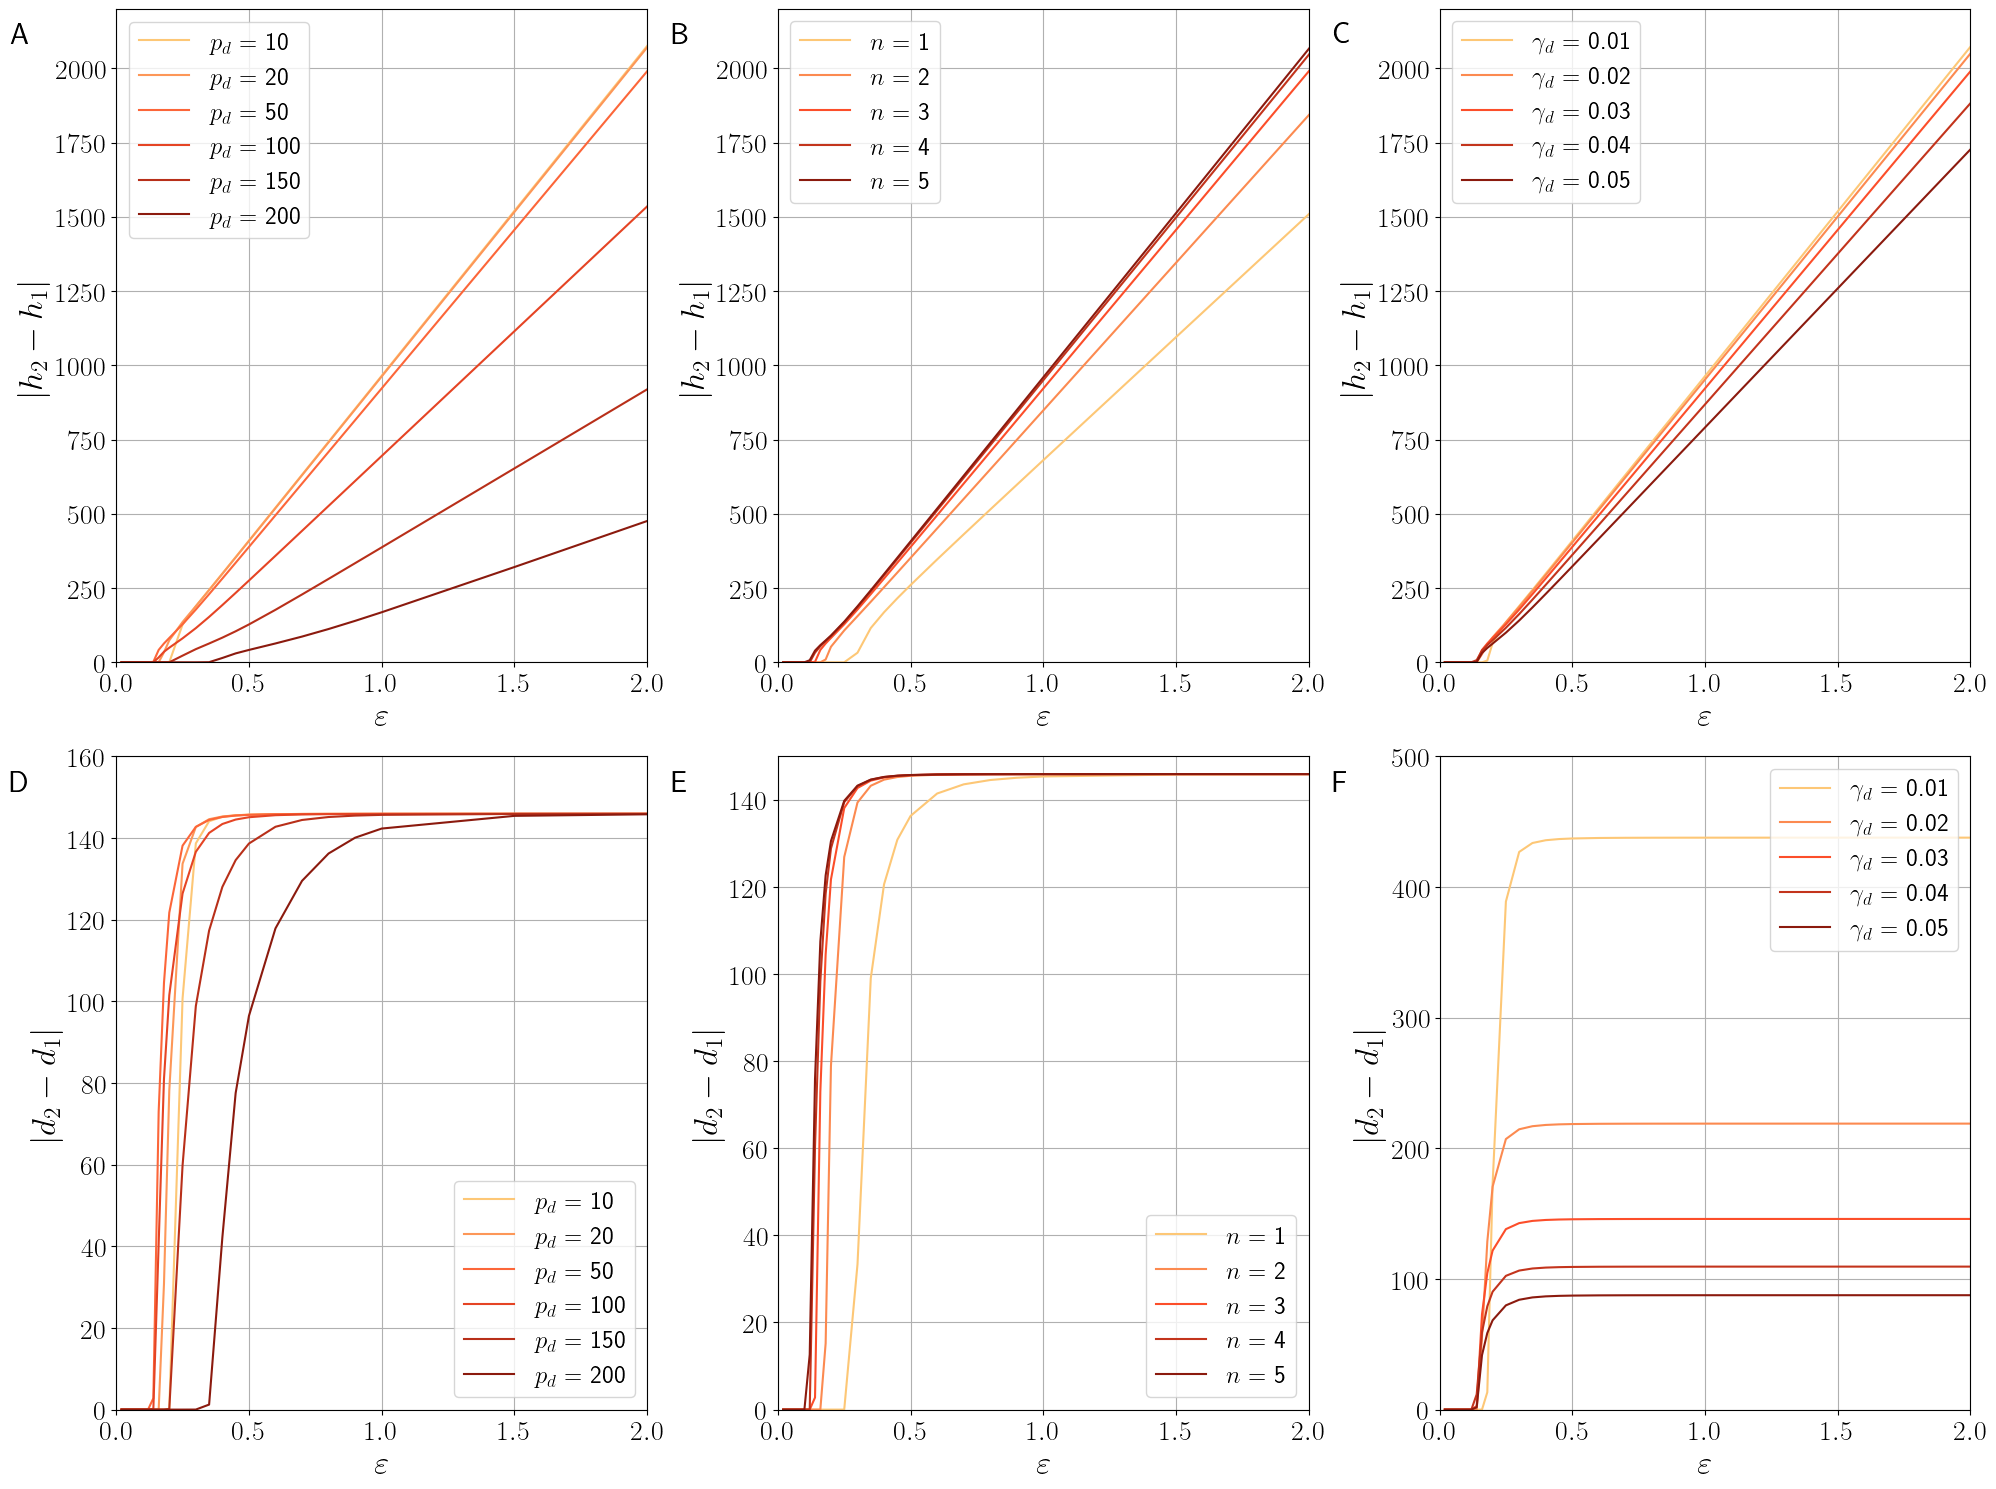

In [23]:
import string

# Define all 6 axes ahead of plotting
fig = plt.figure(figsize=(20, 15))

# Subplot definitions
ax1 = plt.subplot(2, 3, 1)
ax2 = plt.subplot(2, 3, 2)
ax3 = plt.subplot(2, 3, 3)
ax4 = plt.subplot(2, 3, 4)
ax5 = plt.subplot(2, 3, 5)
ax6 = plt.subplot(2, 3, 6)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]



# --- Plotting logic remains unchanged ---
# Plot 1 and 4: p_ds
k = len(p_ds)
colours = vis.get_hes_colors(k)
for i in range(k):
    ax1.plot(epsilons, mean_diff_pd_check[0][i,:], label=fr'$p_d$ = {p_ds[i]}', color=colours[i])
    ax4.plot(epsilons, mean_diff_pd_check[2][i,:], label=fr'$p_d$ = {p_ds[i]}', color=colours[i])
for ax, ylabel in zip([ax1, ax4], ['$|h_2 - h_1|$', '$|d_2 - d_1|$']):
    ax.set_xlabel(r'$\varepsilon$', fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.tick_params(labelsize=20)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2200)
    ax.grid()
    ax.legend(fontsize=18)
ax4.set_ylim(0, 160)

# Plot 2 and 5: hill coefficients
k = len(hill_coeffs)
colours = vis.get_hes_colors(k)
for i in range(k):
    ax2.plot(epsilons, mean_diff_n_check[0][i,:], label=fr'$n$ = {hill_coeffs[i]}', color=colours[i])
    ax5.plot(epsilons, mean_diff_n_check[2][i,:], label=fr'$n$ = {hill_coeffs[i]}', color=colours[i])
for ax, ylabel in zip([ax2, ax5], ['$|h_2 - h_1|$', '$|d_2 - d_1|$']):
    ax.set_xlabel(r'$\varepsilon$', fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.tick_params(labelsize=20)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2200)
    ax.grid()
    ax.legend(fontsize=18)
ax5.set_ylim(0, 150)

# Plot 3 and 6: gamma_d
k = len(gamma_ds)
colours = vis.get_hes_colors(k)
for i in range(k):
    ax3.plot(epsilons, mean_diff_gamma_check[0][i,:], label=fr'$\gamma_d$ = {gamma_ds[i]}', color=colours[i])
    ax6.plot(epsilons, mean_diff_gamma_check[2][i,:], label=fr'$\gamma_d$ = {gamma_ds[i]}', color=colours[i])
for ax, ylabel in zip([ax3, ax6], ['$|h_2 - h_1|$', '$|d_2 - d_1|$']):
    ax.set_xlabel(r'$\varepsilon$', fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.tick_params(labelsize=20)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2200)
    ax.grid()
    ax.legend(fontsize=18)
ax6.set_ylim(0, 500)

# Add subplot lettering: (A), (B), ..., (F)
for i, ax in enumerate(axes):
    ax.text(
        -0.20, 0.98, f'{string.ascii_uppercase[i]}', 
        transform=ax.transAxes, fontsize=22, fontweight='bold', va='top'
    )
    
plt.tight_layout()
# plt.savefig('mean_diff_results.png', dpi=600)
plt.show()


## Plot for all parameters with internal oscillator

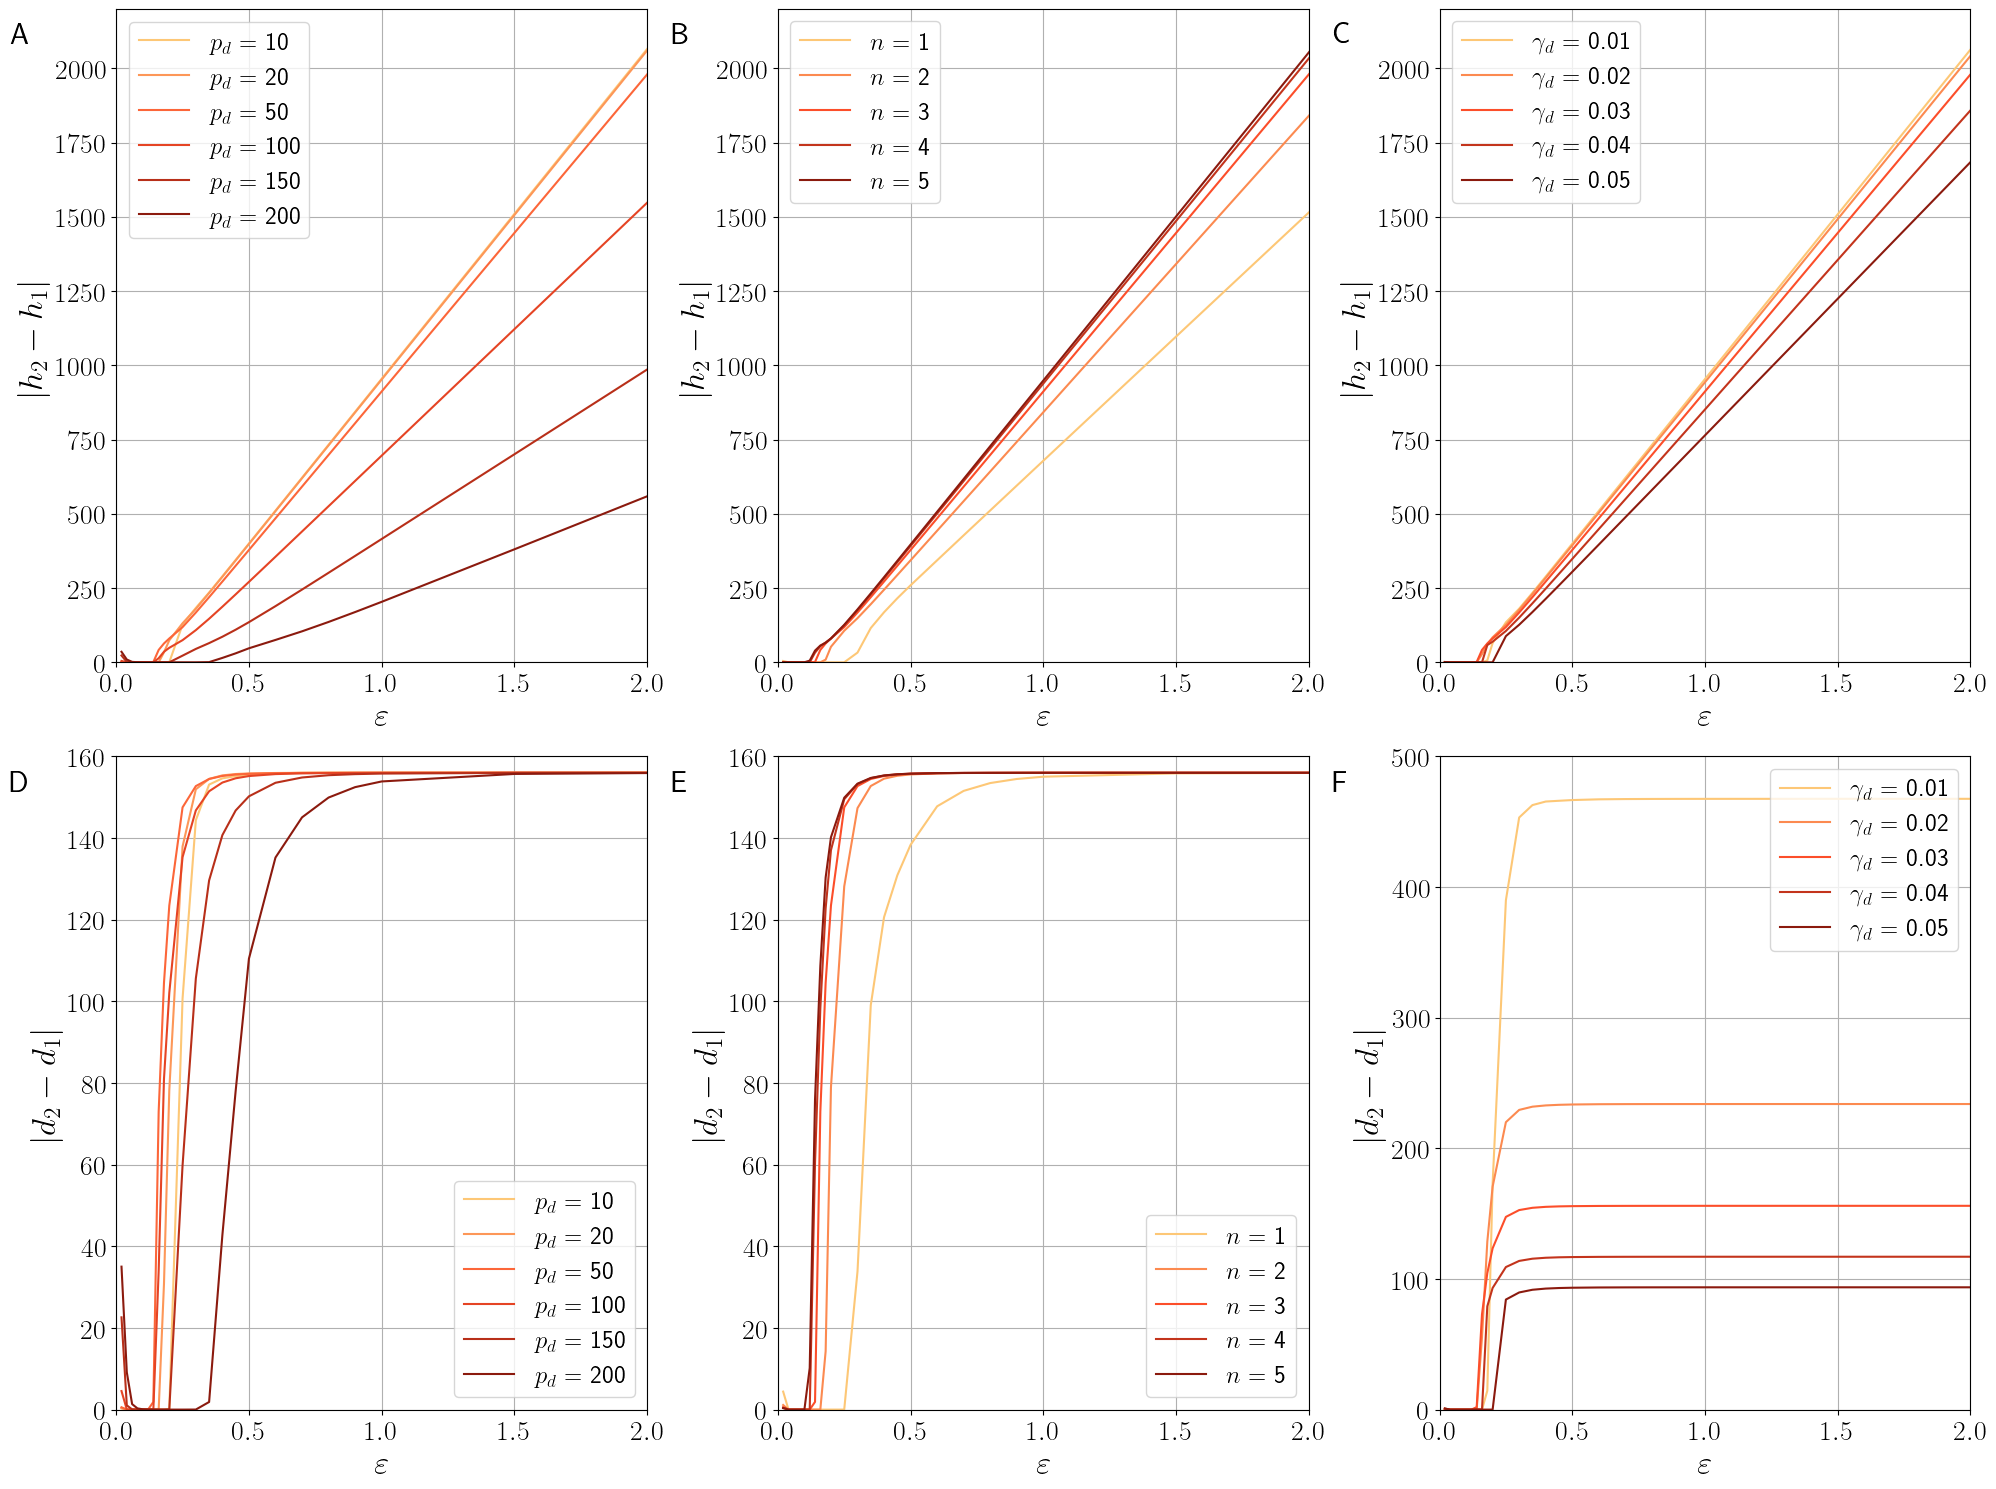

In [ ]:
import string

# Define all 6 axes ahead of plotting
fig = plt.figure(figsize=(20, 15))

# Subplot definitions
ax1 = plt.subplot(2, 3, 1)
ax2 = plt.subplot(2, 3, 2)
ax3 = plt.subplot(2, 3, 3)
ax4 = plt.subplot(2, 3, 4)
ax5 = plt.subplot(2, 3, 5)
ax6 = plt.subplot(2, 3, 6)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]



# --- Plotting logic remains unchanged ---
# Plot 1 and 4: p_ds
k = len(p_ds)
colours = vis.get_hes_colors(k)
for i in range(k):
    ax1.plot(epsilons, mean_diff_pd_hes_check[0][i,:], label=fr'$p_d$ = {p_ds[i]}', color=colours[i])
    ax4.plot(epsilons, mean_diff_pd_hes_check[2][i,:], label=fr'$p_d$ = {p_ds[i]}', color=colours[i])
for ax, ylabel in zip([ax1, ax4], ['$|h_2 - h_1|$', '$|d_2 - d_1|$']):
    ax.set_xlabel(r'$\varepsilon$', fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.tick_params(labelsize=20)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2200)
    ax.grid()
    ax.legend(fontsize=18)
ax4.set_ylim(0, 160)

# Plot 2 and 5: hill coefficients
k = len(hill_coeffs)
colours = vis.get_hes_colors(k)
for i in range(k):
    ax2.plot(epsilons, mean_diff_n_hes_check[0][i,:], label=fr'$n$ = {hill_coeffs[i]}', color=colours[i])
    ax5.plot(epsilons, mean_diff_n_hes_check[2][i,:], label=fr'$n$ = {hill_coeffs[i]}', color=colours[i])
for ax, ylabel in zip([ax2, ax5], ['$|h_2 - h_1|$', '$|d_2 - d_1|$']):
    ax.set_xlabel(r'$\varepsilon$', fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.tick_params(labelsize=20)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2200)
    ax.grid()
    ax.legend(fontsize=18)
ax5.set_ylim(0, 160)

# Plot 3 and 6: gamma_d
k = len(gamma_ds)
colours = vis.get_hes_colors(k)
for i in range(k):
    ax3.plot(epsilons, mean_diff_gamma_hes_check[0][i,:], label=fr'$\gamma_d$ = {gamma_ds[i]}', color=colours[i])
    ax6.plot(epsilons, mean_diff_gamma_hes_check[2][i,:], label=fr'$\gamma_d$ = {gamma_ds[i]}', color=colours[i])
for ax, ylabel in zip([ax3, ax6], ['$|h_2 - h_1|$', '$|d_2 - d_1|$']):
    ax.set_xlabel(r'$\varepsilon$', fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.tick_params(labelsize=20)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2200)
    ax.grid()
    ax.legend(fontsize=18)
ax6.set_ylim(0, 500)

# Add subplot lettering: (A), (B), ..., (F)
for i, ax in enumerate(axes):
    ax.text(
        -0.20, 0.98, f'{string.ascii_uppercase[i]}', 
        transform=ax.transAxes, fontsize=22, fontweight='bold', va='top'
    )
    
    
plt.tight_layout()
# plt.savefig('mean_diff_hes_results.png', dpi=600)
plt.show()

# Synchronised oscillatory behaviour 

C:\Users\kbmcd\AppData\Local\Temp\ipykernel_15496\829722649.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGn')


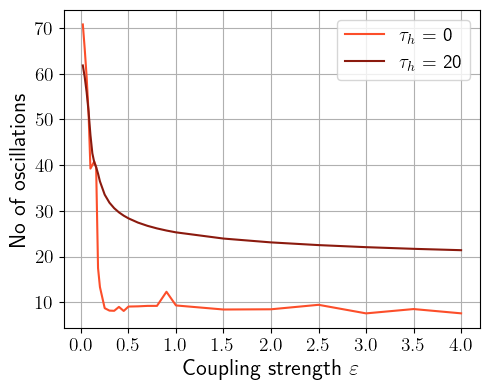

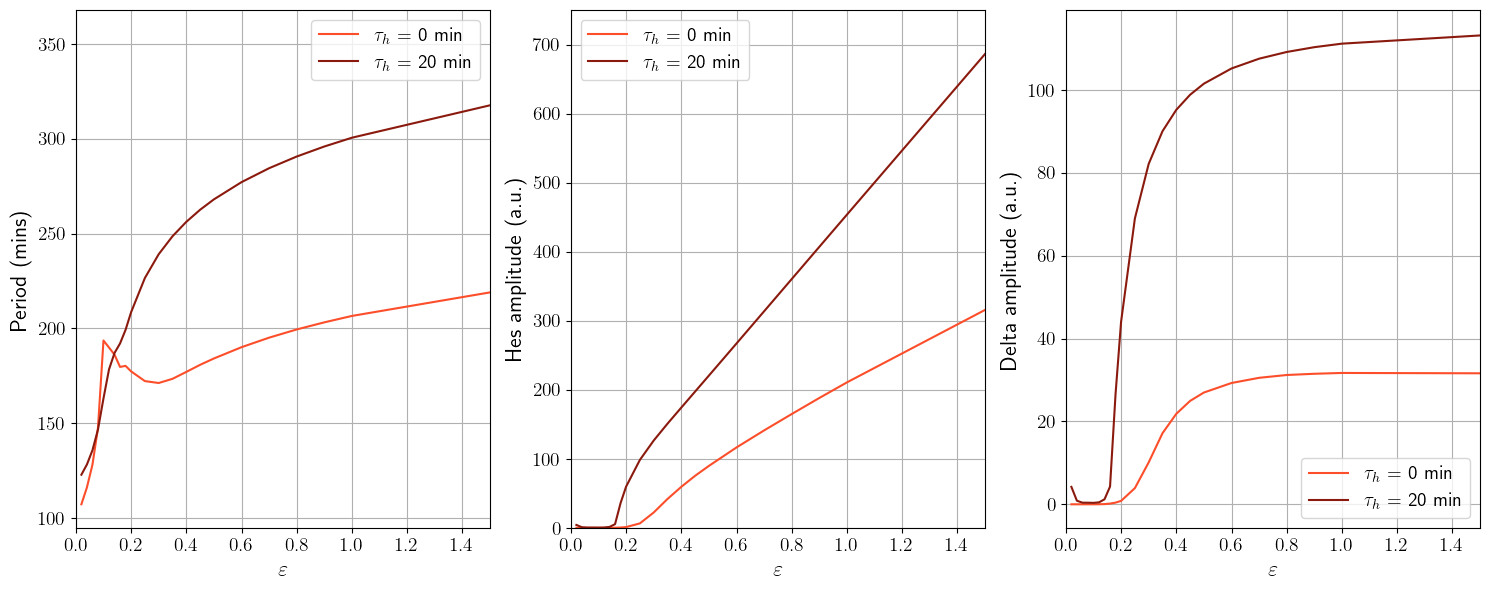

In [8]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(epsilons, result_synced_index_pd[1][2,:]*dt, color = hescolor2, label = r'$\tau_h$ = 0' )
# plt.plot(epsilons, result_synced_index_pd_hes[1][2,:]*dt, color = hescolor3, label = r'$\tau_h$ = 20')
# plt.xlabel(r'$\varepsilon$', fontsize=16)
# plt.ylabel('Time (mins)', fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.grid()
# plt.legend(fontsize=14)

# plt.subplot(1, 2, 2)
# plt.plot(epsilons, result_synced_index_pd[1][2,:]*dt/result_period_synced_pd[0][2,:], color = hescolor2, label = r'$\tau_h$ = 0' )
# plt.plot(epsilons, result_synced_index_pd_hes[1][2,:]*dt/result_period_synced_pd_hes[0][2,:], color = hescolor3, label = r'$\tau_h$ = 20')
# plt.xlabel(r'$\varepsilon$', fontsize=16)
# plt.ylabel('Number of waves', fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.grid()
# plt.legend(fontsize=14)
# plt.tight_layout()

# # plt.savefig('synced_index_pd.png', dpi=600)

plt.figure(figsize=(5, 4))
plt.plot(epsilons, result_synced_index_pd[1][2,:]*dt/result_period_synced_pd[0][2,:], color = hescolor2, label = r'$\tau_h$ = 0' )
plt.plot(epsilons, result_synced_index_pd_hes[1][2,:]*dt/result_period_synced_pd_hes[0][2,:], color = hescolor3, label = r'$\tau_h$ = 20')
plt.xlabel(r'Coupling strength $\varepsilon$', fontsize=16)
plt.ylabel('No of oscillations', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.tight_layout()

# plt.savefig('synced_index_pd.png', dpi=600)

cmap = cm.get_cmap('YlGn') 
colour = cmap(0.6)  # Use a color from the colormap

plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.plot(epsilons, result_period_synced_pd[0][2,:], color = hescolor2, label=rf'$\tau_h$ = 0 min')
plt.plot(epsilons, result_period_synced_pd_hes[0][2,:], color = hescolor3,label=rf'$\tau_h$ = 20 min')
plt.xlabel(r'$\varepsilon$', fontsize=16)
plt.ylabel('Period (mins)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, epsilons[21])
plt.grid()

plt.subplot(1,3,2)
plt.plot(epsilons, result_amplitude_synced_pd[0][2,:], color = hescolor2, label=rf'$\tau_h$ = 0 min')
plt.plot(epsilons, result_amplitude_synced_pd_hes[0][2,:], color = hescolor3, label=rf'$\tau_h$ = 20 min')
plt.xlabel(r'$\varepsilon$', fontsize=16)
plt.ylabel('Hes amplitude (a.u.)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, epsilons[21])
plt.ylim(0, 750)
plt.grid()

plt.subplot(1,3,3)
plt.plot(epsilons, result_amplitude_synced_pd[2][2,:], color = hescolor2, label=rf'$\tau_h$ = 0 min')
plt.plot(epsilons, result_amplitude_synced_pd_hes[2][2,:], color = hescolor3, label=rf'$\tau_h$ = 20 min')
plt.xlabel(r'$\varepsilon$', fontsize=16)
plt.ylabel('Delta amplitude (a.u.)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, epsilons[21])
plt.grid()

plt.tight_layout()
# plt.savefig('synced_period_amplitude.png', dpi=600)
plt.show()


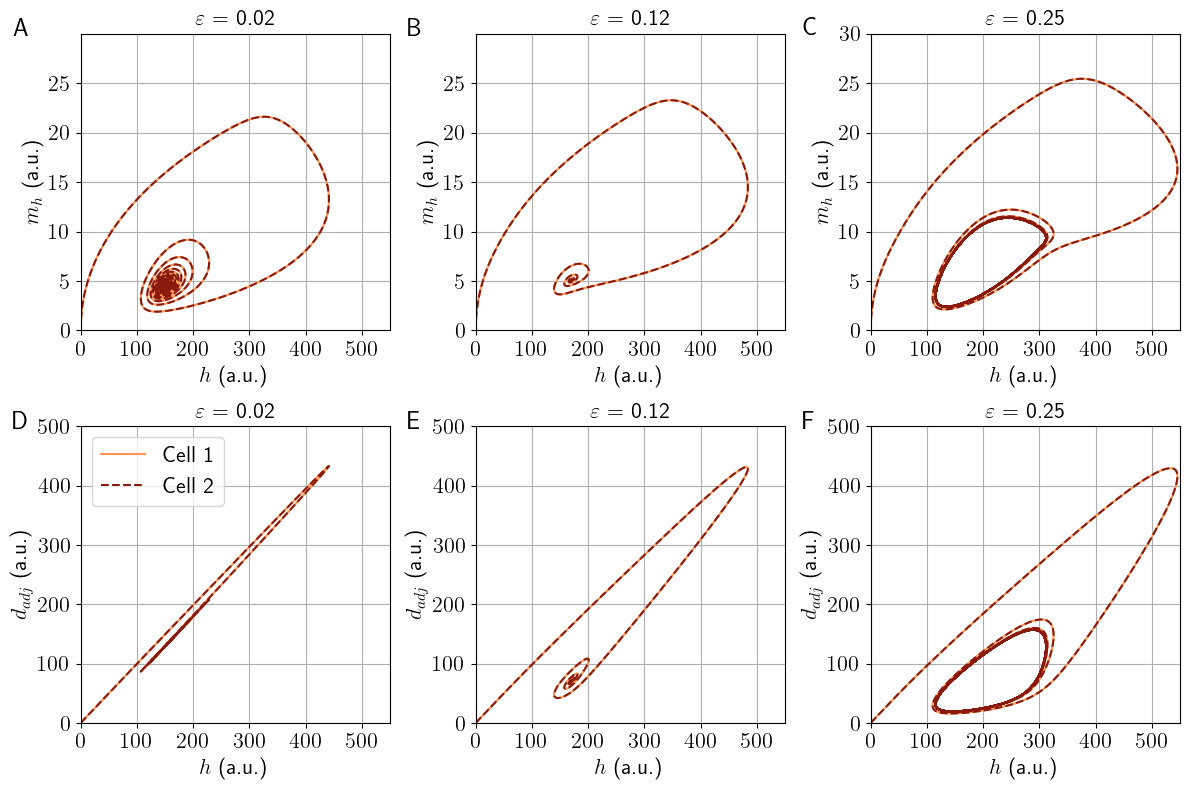

In [16]:
plt.figure(figsize=(12, 8))

# Define subplot labels
subplot_labels = ['A', 'D', 'B', 'E', 'C', 'F']
label_idx = 0  # to cycle through subplot labels

for i_strength in [0, 5, 10]:
    
    h_data = results_pd_hes_uni[2, i_strength, :, 0, :]
    m_h_data = results_pd_hes_uni[2, i_strength, :, 2, :]
    d_data = results_pd_hes_uni[2, i_strength, :, 1, :]
    i = int(i_strength / 5 + 1)

    # Top row: mh vs h
    ax1 = plt.subplot(2, 3, i)
    ax1.plot(h_data[:, 0], m_h_data[:, 0], label='Cell 1', color=colours[1], ls='-')
    ax1.plot(h_data[:, 1], m_h_data[:, 1], label='Cell 2', color=colours[-1], ls='--')
    ax1.set_xlabel(r'$h$ (a.u.)', fontsize=16)
    ax1.set_ylabel(r'$m_h$ (a.u.)', fontsize=16)
    ax1.set_xticks(ax1.get_xticks())
    ax1.set_yticks(ax1.get_yticks())
    ax1.tick_params(labelsize=16)
    ax1.set_title(fr'$\varepsilon$ = {epsilons[i_strength]}', fontsize=16)
    ax1.grid()
    ax1.set_xlim(0, 550)
    ax1.set_ylim(0, 30)
    ax1.text(-0.22, 1.05, subplot_labels[label_idx], transform=ax1.transAxes,
             fontsize=18, fontweight='bold', va='top', ha='left')
    label_idx += 1

    # Bottom row: d_adj vs h
    ax2 = plt.subplot(2, 3, i + 3)
    ax2.plot(h_data[:, 0], d_data[:, 1], label='Cell 1', color=colours[1], ls='-')
    ax2.plot(h_data[:, 1], d_data[:, 0], label='Cell 2', color=colours[-1], ls='--')
    ax2.set_xlabel(r'$h$ (a.u.)', fontsize=16)
    ax2.set_ylabel(r'$d_{adj}$ (a.u.)', fontsize=16)
    ax2.set_xticks(ax2.get_xticks())
    ax2.set_yticks(ax2.get_yticks())
    ax2.tick_params(labelsize=16)
    ax2.set_title(fr'$\varepsilon$ = {epsilons[i_strength]}', fontsize=16)
    ax2.grid()
    ax2.set_xlim(0, 550)
    ax2.set_ylim(0, 500)
    ax2.text(-0.22, 1.05, subplot_labels[label_idx], transform=ax2.transAxes,
             fontsize=18, fontweight='bold', va='top', ha='left')
    label_idx += 1

    if i_strength == 0:
        ax2.legend(fontsize=16)

plt.tight_layout()
# plt.savefig('two-cell-limit.png', dpi=600)


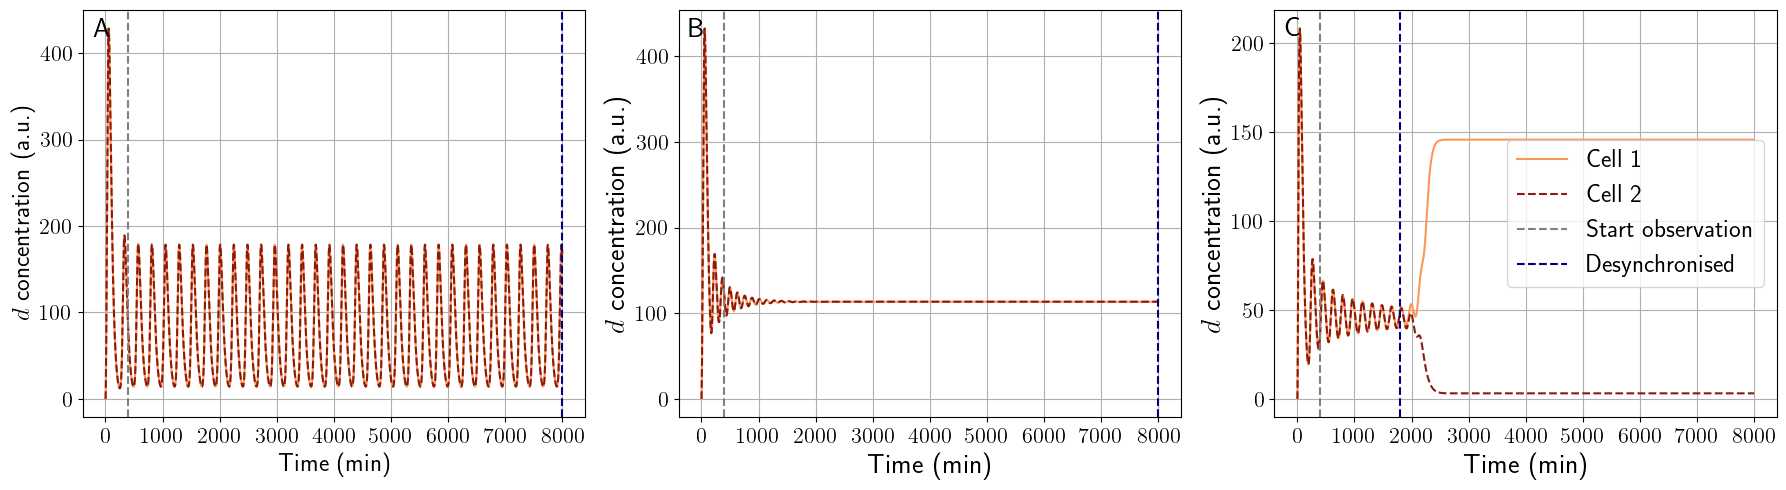

In [34]:
colours = vis.get_hes_colors(len(p_ds))


time = np.arange(0, num_tsteps*dt, dt)
i = 11
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(time, results_pd_hes_uni[2, i, :, 1, 0], label='Cell 1', color= colours[1])
plt.plot(time, results_pd_hes_uni[2, i, :, 1, 1], label='Cell 2', ls = '--', color= colours[-1])
plt.axvline(x=(result_synced_index_pd_hes[0][2, i]+time_settled)*dt, color='gray', linestyle='--', label='Start observation')
plt.axvline(x=(result_synced_index_pd_hes[1][2, i]+time_settled)*dt, color='navy', linestyle='--', label='')
plt.xlabel('Time (min)', fontsize=18)
plt.ylabel(r'$d$ concentration (a.u.)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
# plt.legend(fontsize=18)
# plt.title(r'$\tau_h$ = 20', fontsize=16)


# Add label A
plt.text(
    0.02, 0.98, 'A',
    transform=plt.gca().transAxes,
    fontsize=20,
    fontweight='bold',
    va='top',
    ha='left'
)

plt.subplot(1, 3, 2)
plt.plot(time, results_pd_hes_uni[2, 1, :, 1, 0], label='Cell 1', color= colours[1])
plt.plot(time, results_pd_hes_uni[2, 1, :, 1, 1], label='Cell 2', ls = '--', color= colours[-1])
plt.axvline(x=(result_synced_index_pd_hes[0][2, 1]+time_settled)*dt, color='gray', linestyle='--', label='Start observation')
plt.axvline(x=(result_synced_index_pd_hes[1][2, 1]+time_settled)*dt, color='navy', linestyle='--', )
plt.xlabel('Time (min)', fontsize=20)
plt.ylabel(r'$d$ concentration (a.u.)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
# plt.legend(fontsize=18)
# plt.title(r'$\tau_h$ = 20', fontsize=16)

plt.text(
    0.02, 0.98, 'B',
    transform=plt.gca().transAxes,
    fontsize=20,
    fontweight='bold',
    va='top',
    ha='left'
)

plt.subplot(1, 3, 3)
plt.plot(time, results_pd_uni[2, i, :, 1, 0], label='Cell 1', color= colours[1])
plt.plot(time, results_pd_uni[2, i, :, 1, 1], label='Cell 2', ls = '--', color= colours[-1])
plt.axvline(x=(result_synced_index_pd[0][2, i]+time_settled)*dt, color='gray', linestyle='--', label='Start observation')
plt.axvline(x=(result_synced_index_pd[1][2, i]+time_settled)*dt, color='navy', linestyle='--', label='Desynchronised')
plt.xlabel('Time (min)', fontsize=20)
plt.ylabel(r'$d$ concentration (a.u.)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.legend(fontsize=18)
# plt.title(r'$\tau_h$ = 0', fontsize=16)

# Add label C
plt.text(
    0.02, 0.98, 'C',
    transform=plt.gca().transAxes,
    fontsize=20,
    fontweight='bold',
    va='top',
    ha='left'
)

plt.tight_layout()
# plt.savefig('example_synced_LI_system.png', dpi=600)

## Desynchronisation plots for no internal oscillator all parameters

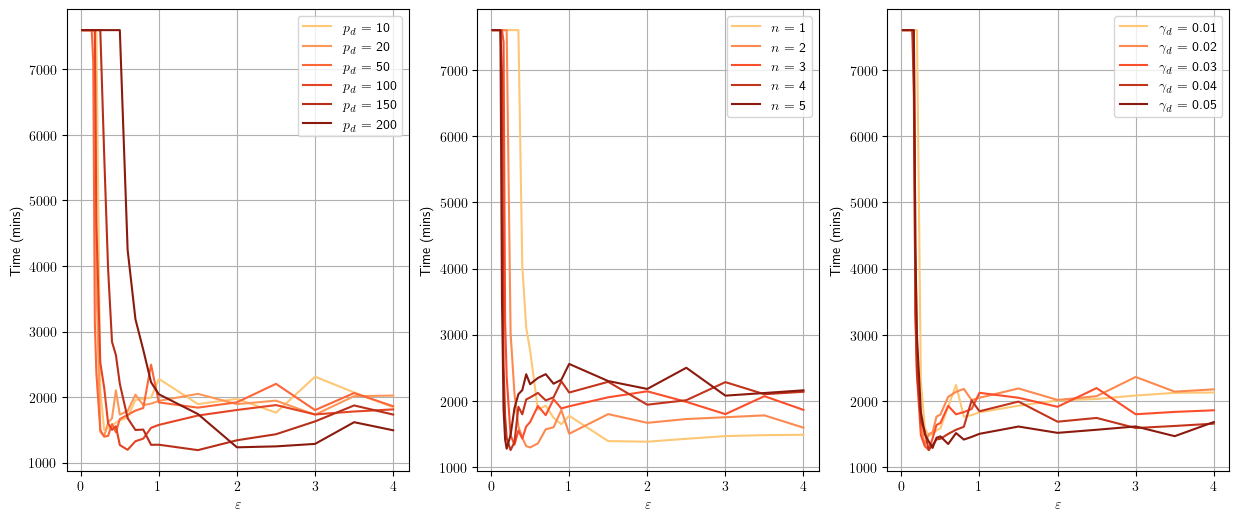

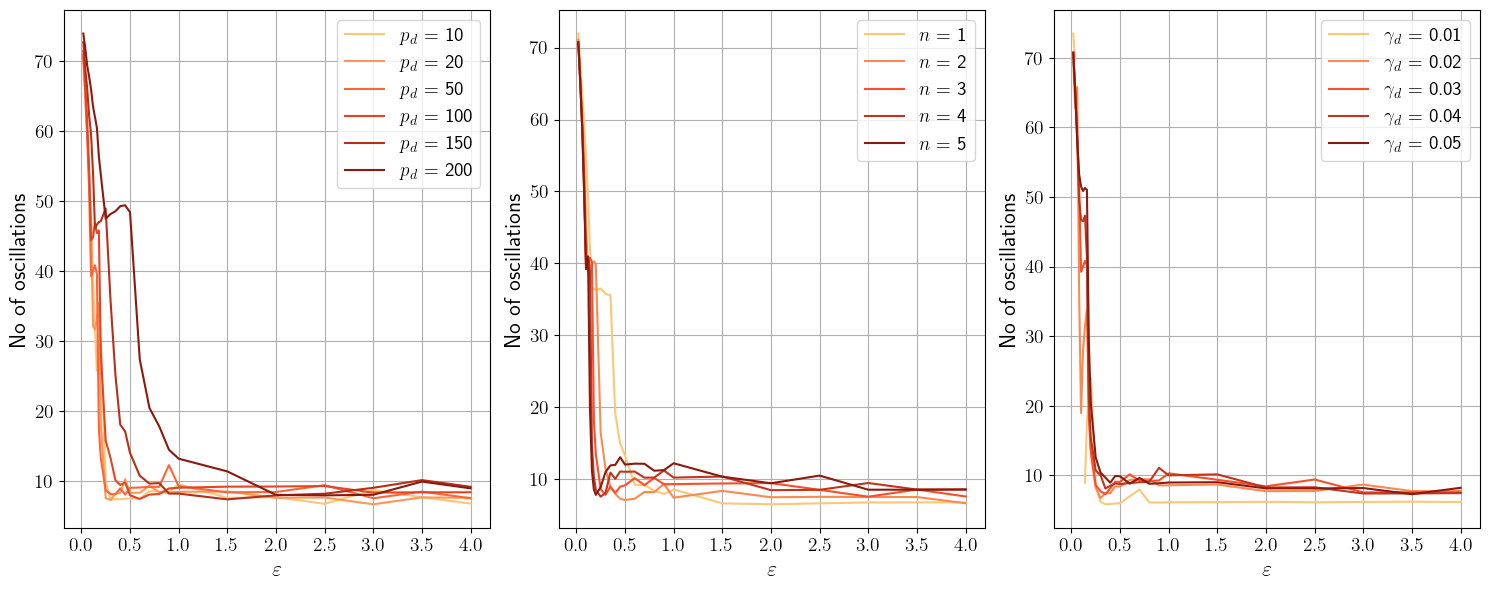

In [41]:
plt.figure(figsize=(15, 6))

colours =vis.get_hes_colors(len(p_ds))
cell_type = ['h', 'd']

plt.subplot(1,3,1)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_synced_index_pd[1][i,:]*dt,  color = colours[i], label=fr'$p_d$ = {p_ds[i]}')
plt.xlabel(r'$\varepsilon$')
plt.ylabel('Time (mins)')
plt.legend()
plt.grid()

colours =vis.get_hes_colors(len(hill_coeffs))

plt.subplot(1,3,2)
for i in range(len(hill_coeffs)):
    plt.plot(epsilons, result_synced_index_n[1][i,:]*dt,  color = colours[i], label=fr'$n$ = {hill_coeffs[i]}')
plt.xlabel(r'$\varepsilon$')
plt.ylabel('Time (mins)')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
colours =vis.get_hes_colors(len(gamma_ds))
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_synced_index_gamma[1][i,:]*dt,  color = colours[i], label=fr'$\gamma_d$ = {gamma_ds[i]}')
plt.xlabel(r'$\varepsilon$')
plt.ylabel('Time (mins)')
plt.legend()
plt.grid()

# plt.savefig('synced_index_no_hes.png', dpi=600)

plt.figure(figsize=(15, 6))

colours =vis.get_hes_colors(len(p_ds))
cell_type = ['h', 'd']

plt.subplot(1,3,1)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_synced_index_pd[1][i,:]*dt/result_period_synced_pd[0][i,:],  color = colours[i], label=fr'$p_d$ = {p_ds[i]}')
plt.xlabel(r'$\varepsilon$', fontsize=16)
plt.ylabel('No of oscillations', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()

colours =vis.get_hes_colors(len(hill_coeffs))

plt.subplot(1,3,2)
for i in range(len(hill_coeffs)):
    plt.plot(epsilons, result_synced_index_n[1][i,:]*dt/result_period_synced_n[0][i,:],  color = colours[i], label=fr'$n$ = {hill_coeffs[i]}')
plt.xlabel(r'$\varepsilon$', fontsize=16)
plt.ylabel('No of oscillations', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()

plt.subplot(1,3,3)
colours =vis.get_hes_colors(len(gamma_ds))
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_synced_index_gamma[1][i,:]*dt/result_period_synced_gamma[0][i,:],  color = colours[i], label=fr'$\gamma_d$ = {gamma_ds[i]}')
plt.xlabel(r'$\varepsilon$', fontsize=16)
plt.ylabel('No of oscillations', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.tight_layout()
# plt.savefig('waves_before_LI.png', dpi=600)


## Plots of period/amplitude for all parameter sweeps

#### Vary pd

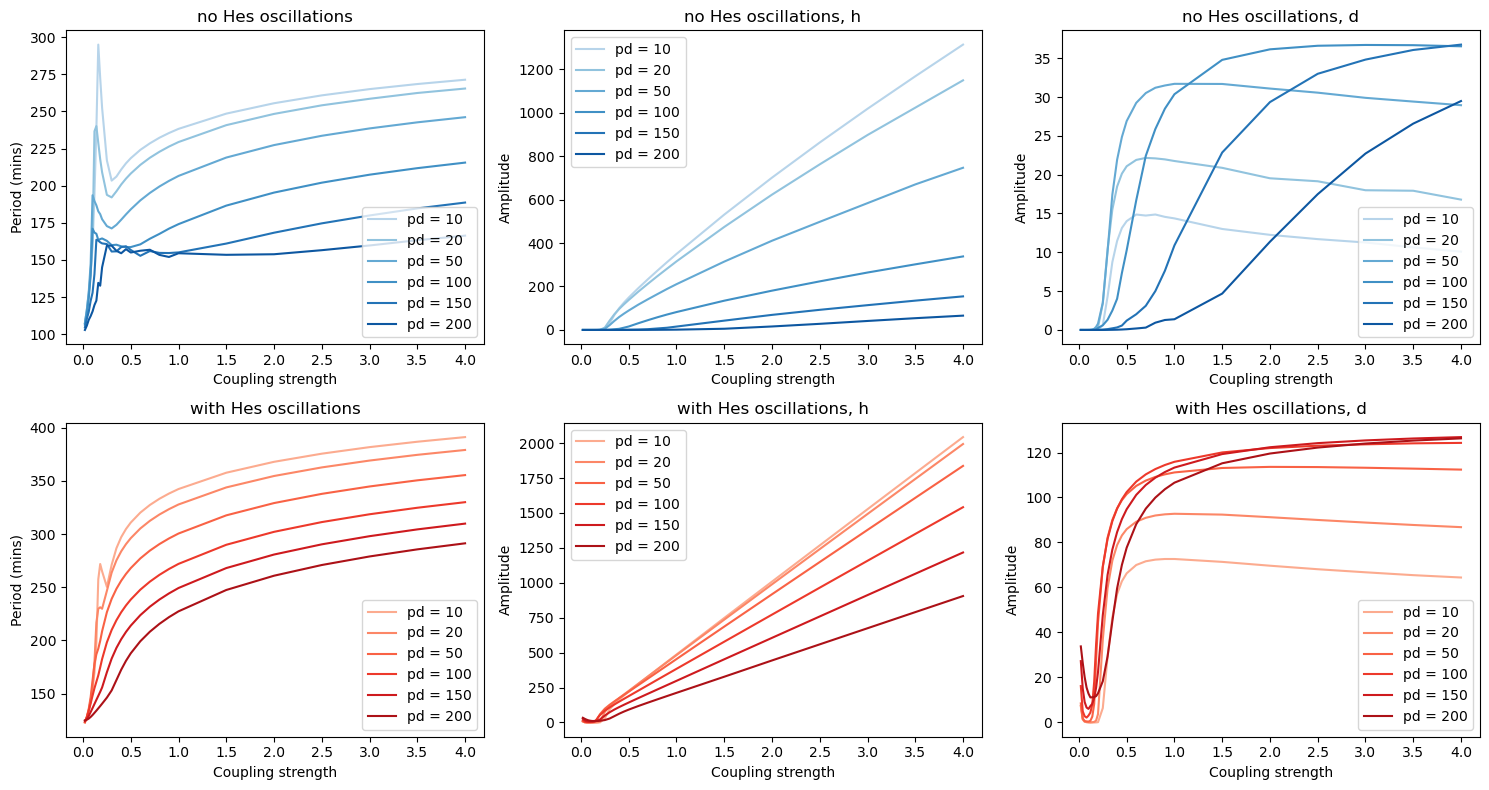

In [ ]:
# Example usage
k = len(p_ds)
blues, reds = vis.get_two_colormaps(k)

cell_type = ['h', 'd']

plt.figure(figsize=(15, 8))

for i in range(len(p_ds)):
    plt.subplot(2,3,1)
    plt.plot(epsilons, result_period_synced_pd[0][i,:],  color = blues[i], label=f'pd = {p_ds[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Period (mins)')
    plt.title(f'no Hes oscillations')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,2)
    plt.plot(epsilons, result_amplitude_synced_pd[0][i,:],  color = blues[i], label=f'pd = {p_ds[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Amplitude')
    plt.title(f'no Hes oscillations, h')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,3)
    plt.plot(epsilons, result_amplitude_synced_pd[2][i,:],  color = blues[i], label=f'pd = {p_ds[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Amplitude')
    plt.title(f'no Hes oscillations, d')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,4)
    plt.plot(epsilons, result_period_synced_pd_hes[0][i,:],  color = reds[i], label=f'pd = {p_ds[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Period (mins)')
    plt.title(f'with Hes oscillations')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,5)
    plt.plot(epsilons, result_amplitude_synced_pd_hes[0][i,:],  color = reds[i], label=f'pd = {p_ds[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Amplitude')
    plt.title(f'with Hes oscillations, h')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,6)
    plt.plot(epsilons, result_amplitude_synced_pd_hes[2][i,:],  color = reds[i], label=f'pd = {p_ds[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Amplitude')
    plt.title(f'with Hes oscillations, d')
    plt.grid()
    plt.legend()

plt.tight_layout()






#### Vary n

IndexError: index 5 is out of bounds for axis 0 with size 5

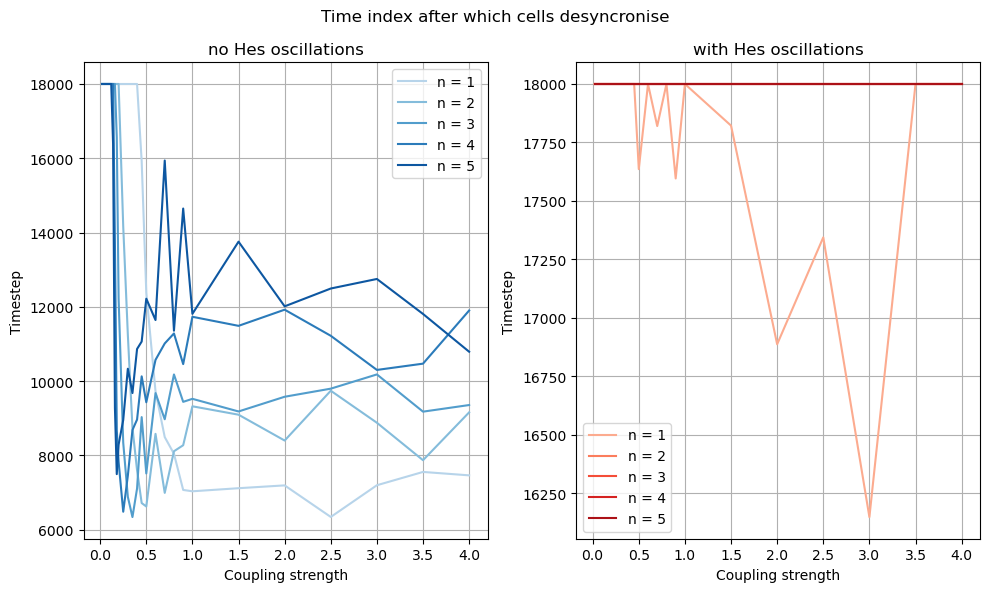

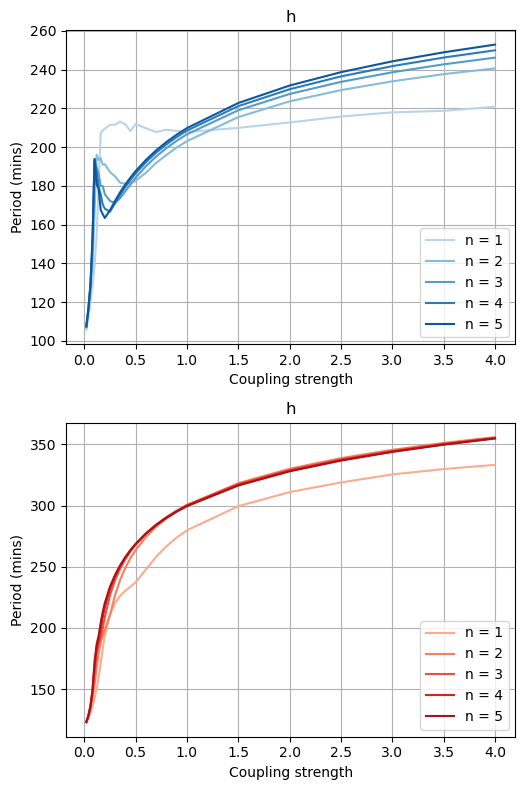

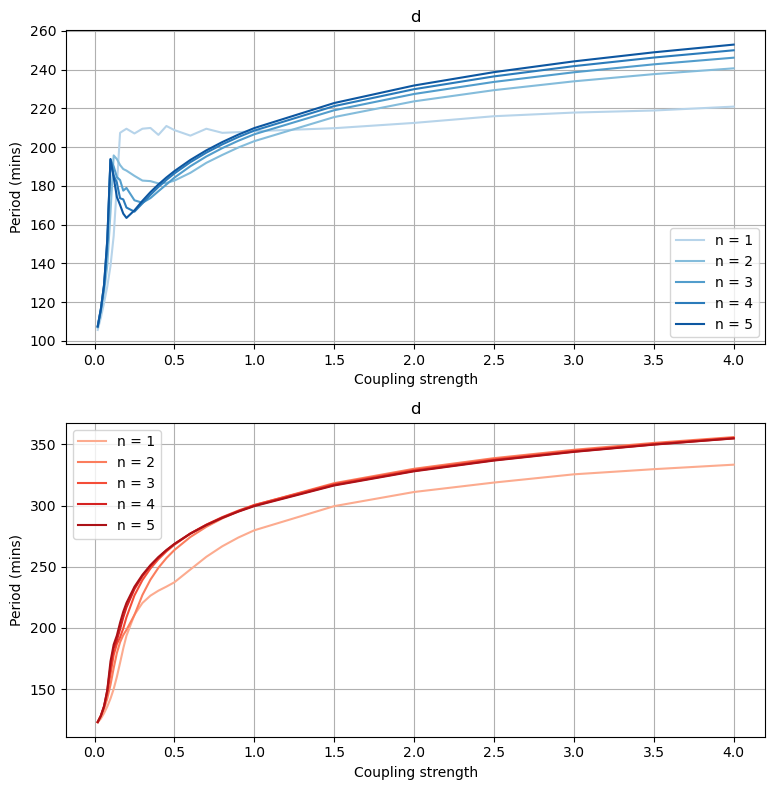

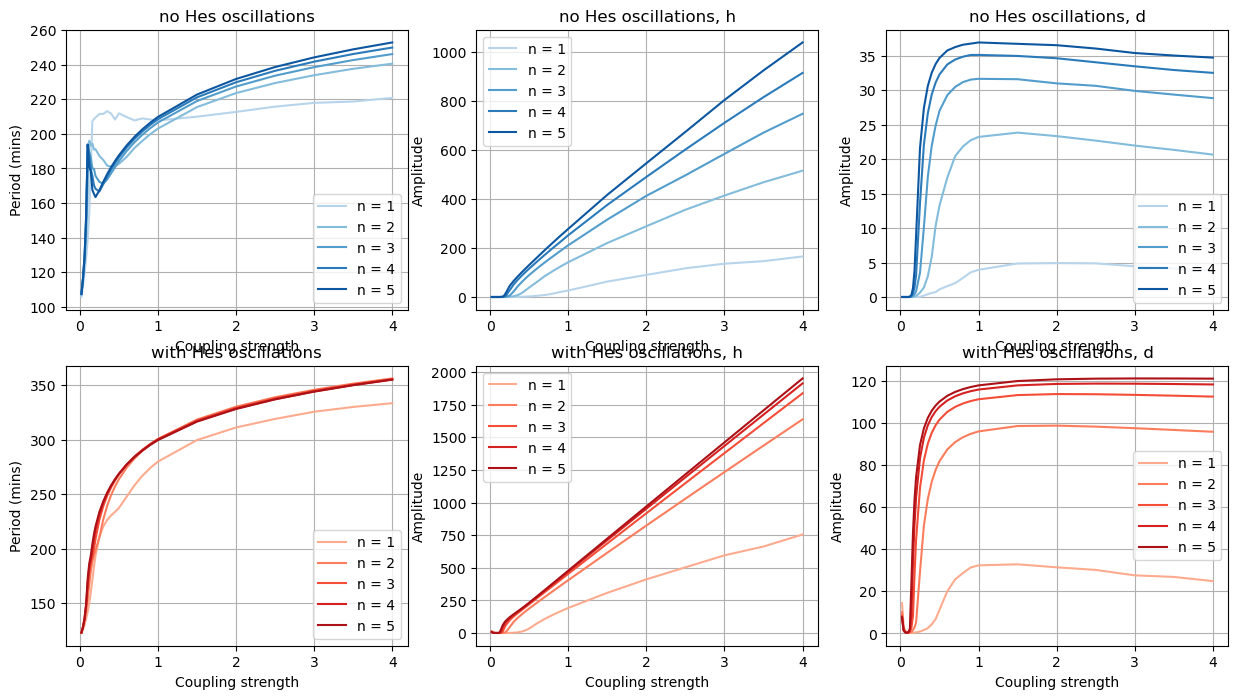

In [75]:

k = len(hill_coeffs)
blues, reds = get_two_colormaps(k)

cell_type = ['h', 'd']

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
for i in range(len(hill_coeffs)):
    plt.plot(epsilons, result_synced_index_n[1][i,:],  color = blues[i], label=f'n = {hill_coeffs[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Timestep')
plt.title('no Hes oscillations')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
for i in range(len(hill_coeffs)):
    plt.plot(epsilons, result_synced_index_n_hes[1][i,:],  color = reds[i], label=f'n = {hill_coeffs[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Timestep')
plt.title('with Hes oscillations')
plt.legend()
plt.grid()
plt.suptitle('Time index after which cells desyncronise')
plt.tight_layout()

plt.figure(figsize=(10, 8))
for c in range(2):
    for i in range(len(hill_coeffs)):
        plt.subplot(2,2,c+1)
        plt.plot(epsilons, result_period_synced_n[c][i,:],  color = blues[i], label=f'n = {hill_coeffs[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell_type[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(2,2,c+1+2)
        plt.plot(epsilons, result_period_synced_n_hes[c][i,:],  color = reds[i], label=f'n = {hill_coeffs[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell_type[c]}')
        plt.grid()
        plt.legend()

    plt.tight_layout()

    plt.figure(figsize=(15, 8))

for i in range(len(p_ds)):
    plt.subplot(2,3,1)
    plt.plot(epsilons, result_period_synced_n[0][i,:],  color = blues[i], label=f'n = {hill_coeffs[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Period (mins)')
    plt.title(f'no Hes oscillations')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,2)
    plt.plot(epsilons, result_amplitude_synced_n[0][i,:],  color = blues[i], label=f'n = {hill_coeffs[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Amplitude')
    plt.title(f'no Hes oscillations, h')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,3)
    plt.plot(epsilons, result_amplitude_synced_n[2][i,:],  color = blues[i], label=f'n = {hill_coeffs[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Amplitude')
    plt.title(f'no Hes oscillations, d')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,4)
    plt.plot(epsilons, result_period_synced_n_hes[0][i,:],  color = reds[i], label=f'n = {hill_coeffs[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Period (mins)')
    plt.title(f'with Hes oscillations')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,5)
    plt.plot(epsilons, result_amplitude_synced_n_hes[0][i,:],  color = reds[i], label=f'n = {hill_coeffs[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Amplitude')
    plt.title(f'with Hes oscillations, h')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,6)
    plt.plot(epsilons, result_amplitude_synced_n_hes[2][i,:],  color = reds[i], label=f'n = {hill_coeffs[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Amplitude')
    plt.title(f'with Hes oscillations, d')
    plt.grid()
    plt.legend()

plt.tight_layout()

#### Vary gamma

IndexError: index 5 is out of bounds for axis 0 with size 5

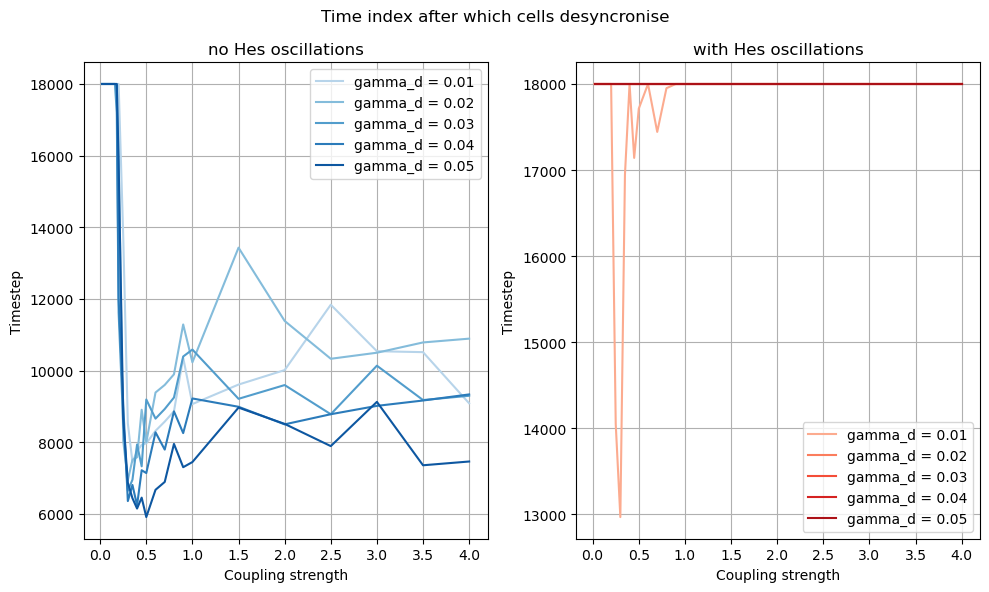

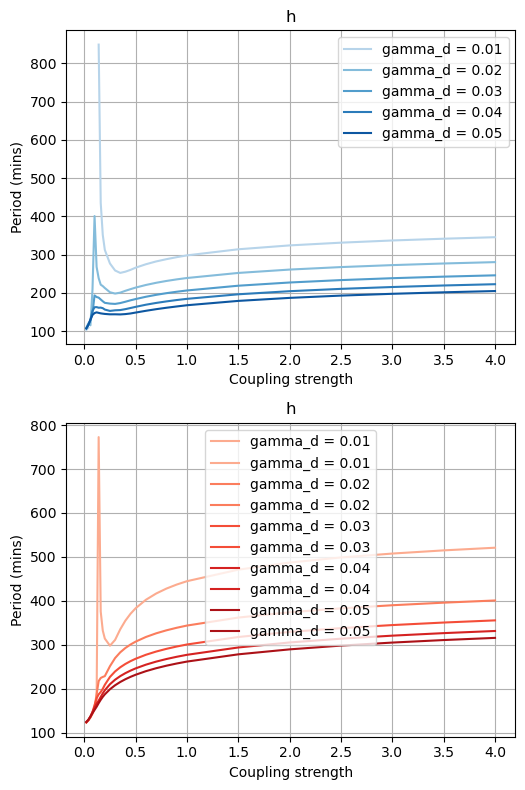

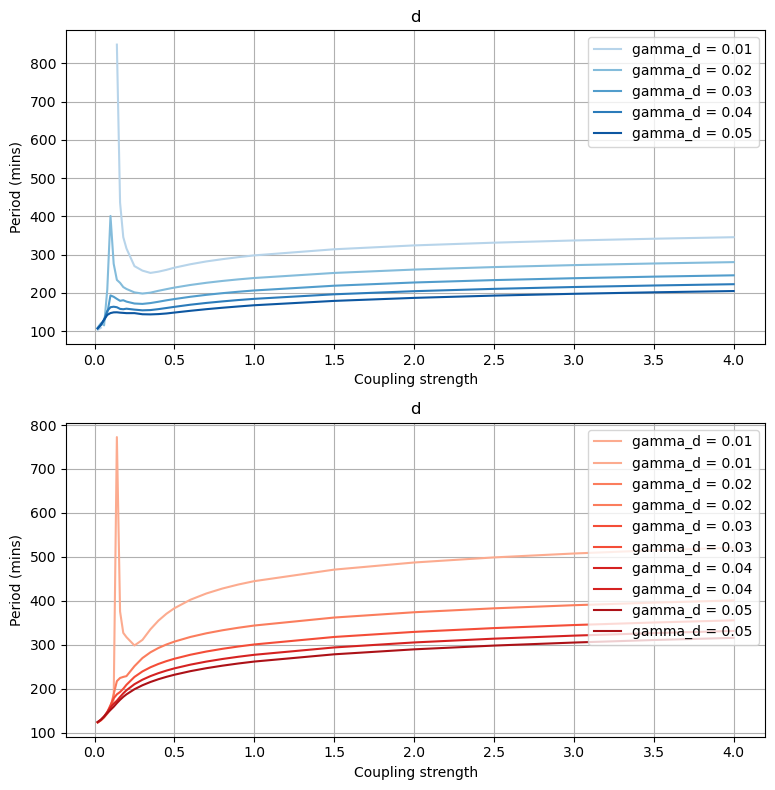

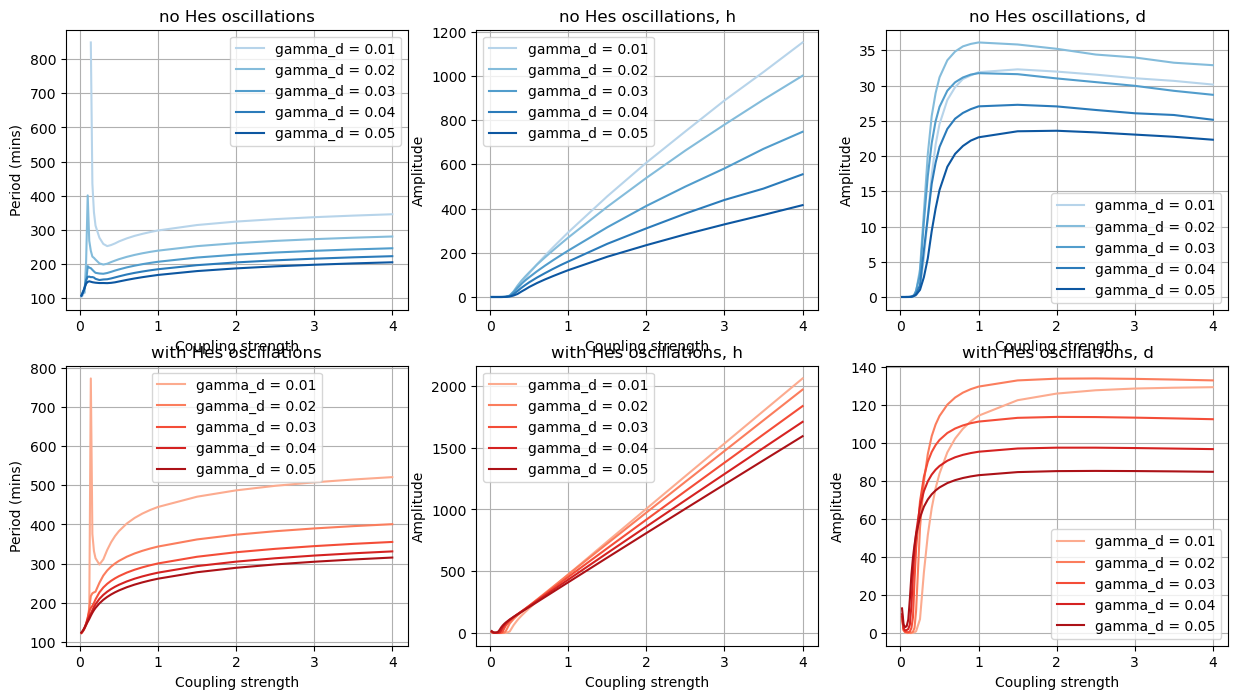

In [76]:

k = len(gamma_ds)
blues, reds = get_two_colormaps(k)

cell_type = ['h', 'd']

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_synced_index_gamma[1][i,:],  color = blues[i], label=f'gamma_d = {gamma_ds[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Timestep')
plt.title('no Hes oscillations')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_synced_index_gamma_hes[1][i,:],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Timestep')
plt.title('with Hes oscillations')
plt.legend()
plt.grid()
plt.suptitle('Time index after which cells desyncronise')
plt.tight_layout()

plt.figure(figsize=(10, 8))
for c in range(2):
    for i in range(len(gamma_ds)):
        plt.subplot(2,2,c+1)
        plt.plot(epsilons, result_period_synced_gamma[c][i,:],  color = blues[i], label=f'gamma_d = {gamma_ds[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell_type[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(2,2,c+1+2)
        plt.plot(epsilons, result_period_synced_gamma_hes[c][i,:],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
        plt.plot(epsilons, result_period_LI_gamma_hes[c][i,:],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell_type[c]}')
        plt.grid()
        plt.legend()

    plt.tight_layout()

    plt.figure(figsize=(15, 8))

for i in range(len(p_ds)):
    plt.subplot(2,3,1)
    plt.plot(epsilons, result_period_synced_gamma[0][i,:],  color = blues[i], label=f'gamma_d = {gamma_ds[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Period (mins)')
    plt.title(f'no Hes oscillations')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,2)
    plt.plot(epsilons, result_amplitude_synced_gamma[0][i,:],  color = blues[i], label=f'gamma_d = {gamma_ds[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Amplitude')
    plt.title(f'no Hes oscillations, h')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,3)
    plt.plot(epsilons, result_amplitude_synced_gamma[2][i,:],  color = blues[i], label=f'gamma_d = {gamma_ds[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Amplitude')
    plt.title(f'no Hes oscillations, d')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,4)
    plt.plot(epsilons, result_period_synced_gamma_hes[0][i,:],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Period (mins)')
    plt.title(f'with Hes oscillations')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,5)
    plt.plot(epsilons, result_amplitude_synced_gamma_hes[0][i,:],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Amplitude')
    plt.title(f'with Hes oscillations, h')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,6)
    plt.plot(epsilons, result_amplitude_synced_gamma_hes[2][i,:],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Amplitude')
    plt.title(f'with Hes oscillations, d')
    plt.grid()
    plt.legend()

plt.tight_layout()

    

# Coupling delay

Effects on synced part of system

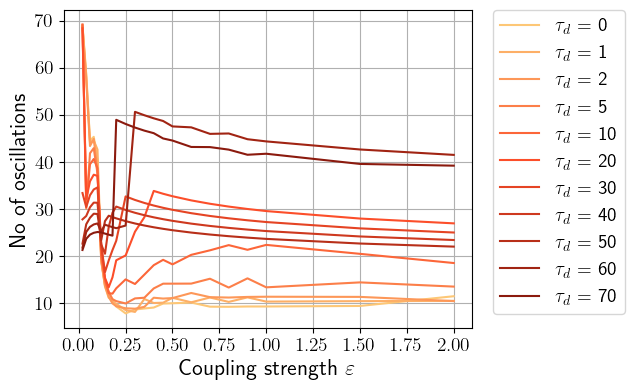

In [32]:
colours =vis.get_hes_colors(len(delays))

index_small_epsilons = 23
small_epsilons = epsilons[:index_small_epsilons]


plt.figure(figsize=(6.5, 4))

for i in range(len(delays)):
    plt.plot(
        small_epsilons,
        result_synced_index_delay[1][i, :index_small_epsilons] * dt / result_period_synced_delay[0][i, :index_small_epsilons],
        label=fr'$\tau_d$ = {delays[i]}',
        color=colours[i]
    )

plt.xlabel(r'Coupling strength $\varepsilon$', fontsize=16)
plt.ylabel('No of oscillations', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

# Place legend outside the plot to the right
plt.legend(
    fontsize=14,
    bbox_to_anchor=(1.05, 1),   # Shift to right outside the axes
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout()

# plt.savefig('delay_synced_index.png', dpi=600, bbox_inches='tight')
plt.show()

<Figure size 1000x600 with 0 Axes>

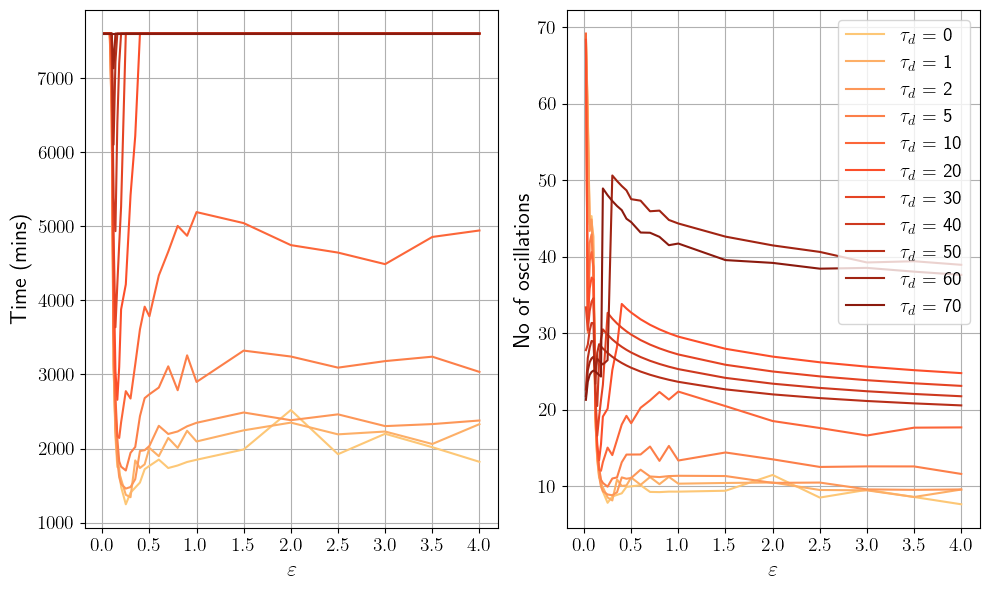

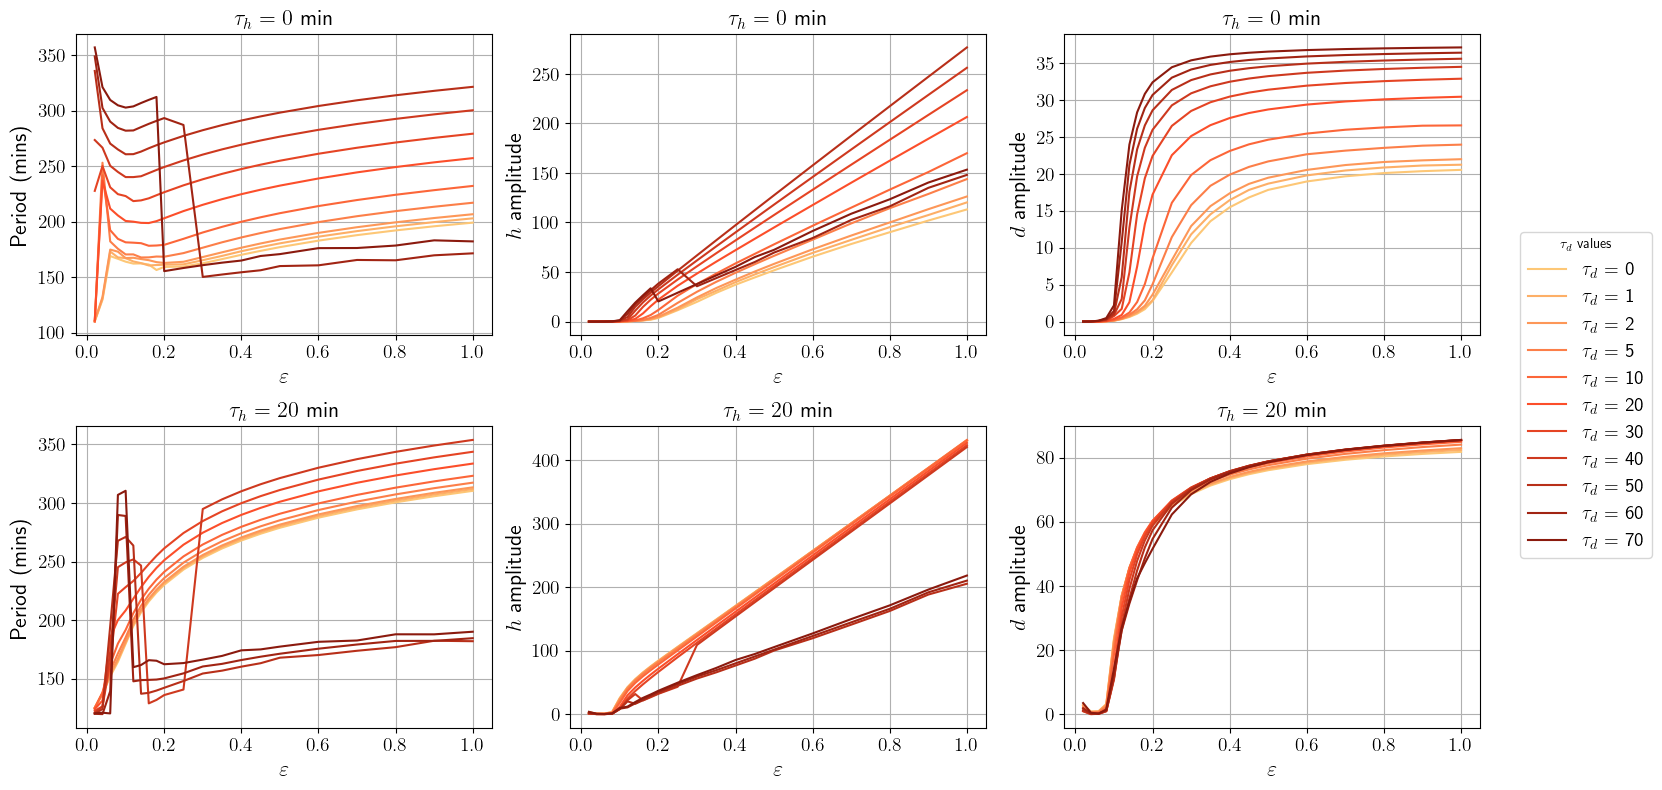

In [ ]:
colours =vis.get_hes_colors(len(delays))

index_small_epsilons = 21
small_epsilons = epsilons[:index_small_epsilons]

plt.figure(figsize=(10, 6))

cell_type = ['h', 'd']
cell = ['h1', 'h2', 'd1', 'd2']
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
for i in range(len(delays)):
    plt.plot(epsilons, result_synced_index_delay[1][i,:]*dt,  color = colours[i], label=fr'$\tau_d$ = {delays[i]}')
plt.xlabel(r' $\varepsilon$', fontsize=16)
plt.ylabel(r'Time (mins)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend()
plt.grid()

plt.subplot(1,2,2)
for i in range(len(delays)):
    plt.plot(epsilons, result_synced_index_delay[1][i,:]*dt/result_period_synced_delay[0][i, :], label = fr'$\tau_d$ = {delays[i]}', color=colours[i])
plt.xlabel(r' $\varepsilon$', fontsize=16)
plt.ylabel(r'No of oscillations', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()

plt.tight_layout()
# plt.savefig('delay_synced_index.png', dpi=600)

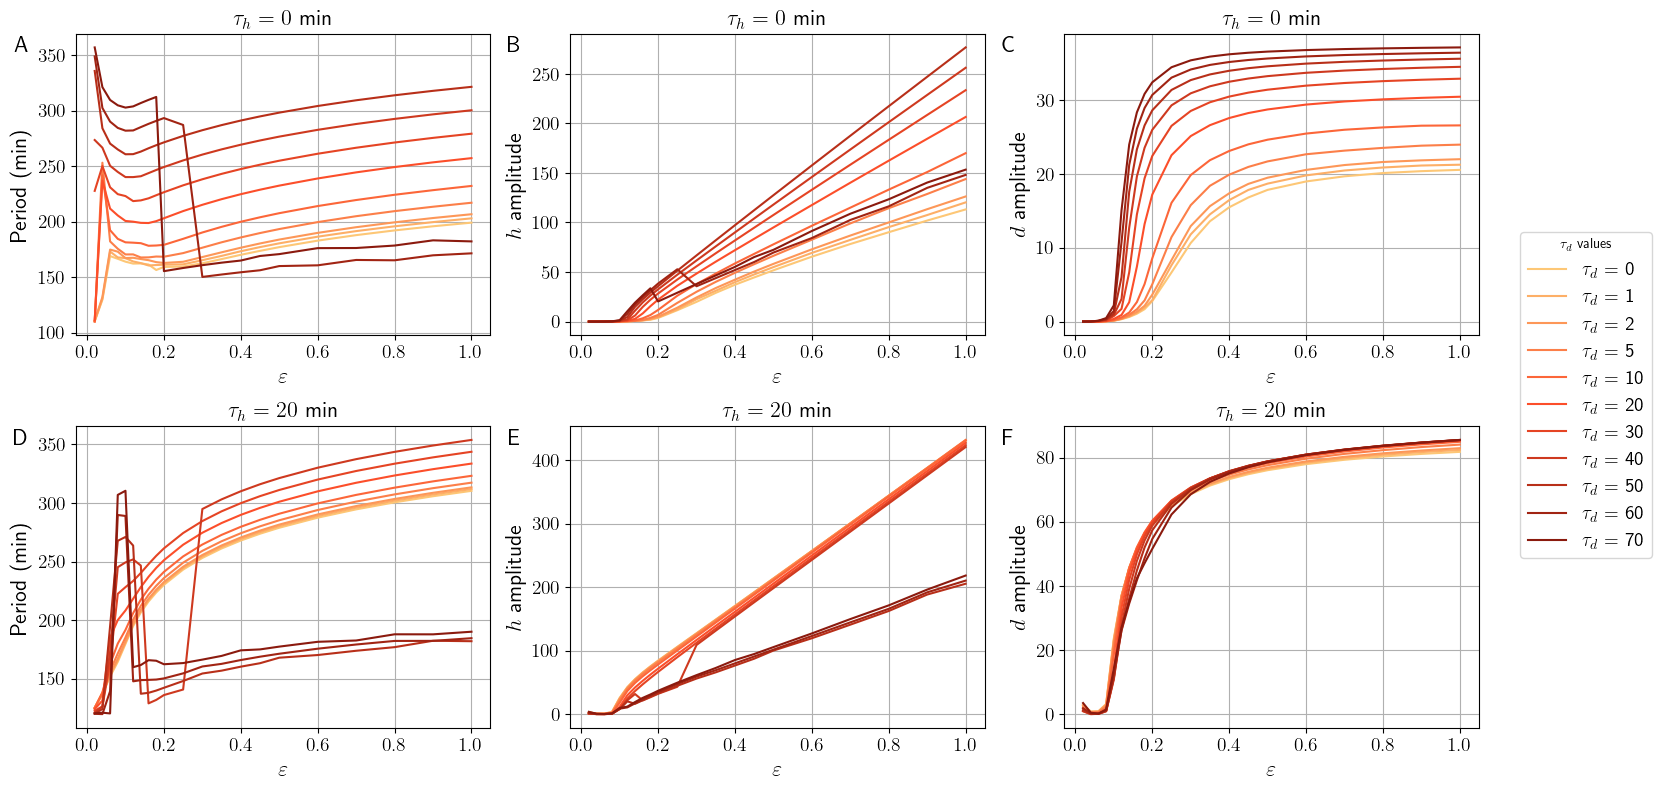

In [35]:

import string

fig = plt.figure(figsize=(15, 8))

# Define all subplot axes first
axes = [plt.subplot(2, 3, i + 1) for i in range(6)]

# Add subplot lettering (A–F)
for i, ax in enumerate(axes):
    ax.text(-0.15, 0.99, f'{string.ascii_uppercase[i]}',
            transform=ax.transAxes,
            fontsize=16,
            fontweight='bold',
            va='top')

# Loop over delays
for i in range(len(delays)):
    # Subplot 1
    axes[0].plot(small_epsilons, result_period_synced_delay[1][i, :index_small_epsilons], color=colours[i], label=fr'$\tau_d$ = {delays[i]}')
    axes[0].set_xlabel(r'$\varepsilon$', fontsize=16)
    axes[0].set_ylabel('Period (min)', fontsize=16)
    axes[0].tick_params(labelsize=14)
    axes[0].grid()
    axes[0].set_title(r'$\tau_h = 0$ min', fontsize=16)

    # Subplot 4
    axes[3].plot(small_epsilons, result_period_synced_delay_hes[1][i, :index_small_epsilons], color=colours[i], label=fr'$\tau_d$ = {delays[i]}')
    axes[3].set_xlabel(r'$\varepsilon$', fontsize=16)
    axes[3].set_ylabel('Period (min)', fontsize=16)
    axes[3].tick_params(labelsize=14)
    axes[3].grid()
    axes[3].set_title(r'$\tau_h = 20$ min', fontsize=16)

    # Subplot 2
    axes[1].plot(small_epsilons, result_amplitude_synced_delay[1][i, :index_small_epsilons], color=colours[i], label=fr'$\tau_d$ = {delays[i]}')
    axes[1].set_xlabel(r'$\varepsilon$', fontsize=16)
    axes[1].set_ylabel('$h$ amplitude', fontsize=16)
    axes[1].tick_params(labelsize=14)
    axes[1].grid()
    axes[1].set_title(r'$\tau_h = 0$ min', fontsize=16)

    # Subplot 5
    axes[4].plot(small_epsilons, result_amplitude_synced_delay_hes[1][i, :index_small_epsilons], color=colours[i], label=fr'$\tau_d$ = {delays[i]}')
    axes[4].set_xlabel(r'$\varepsilon$', fontsize=16)
    axes[4].set_ylabel('$h$ amplitude', fontsize=16)
    axes[4].tick_params(labelsize=14)
    axes[4].grid()
    axes[4].set_title(r'$\tau_h = 20$ min', fontsize=16)

    # Subplot 3
    axes[2].plot(small_epsilons, result_amplitude_synced_delay[3][i, :index_small_epsilons], color=colours[i], label=fr'$\tau_d$ = {delays[i]}')
    axes[2].set_xlabel(r'$\varepsilon$', fontsize=16)
    axes[2].set_ylabel('$d$ amplitude', fontsize=16)
    axes[2].tick_params(labelsize=14)
    axes[2].grid()
    axes[2].set_title(r'$\tau_h = 0$ min', fontsize=16)

    # Subplot 6
    axes[5].plot(small_epsilons, result_amplitude_synced_delay_hes[3][i, :index_small_epsilons], color=colours[i], label=fr'$\tau_d$ = {delays[i]}')
    axes[5].set_xlabel(r'$\varepsilon$', fontsize=16)
    axes[5].set_ylabel('$d$ amplitude', fontsize=16)
    axes[5].tick_params(labelsize=14)
    axes[5].grid()
    axes[5].set_title(r'$\tau_h = 20$ min', fontsize=16)

# Add one legend to the right of the figure
handles, labels = axes[5].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
           fontsize=14, title=r'$\tau_d$ values')

plt.tight_layout()
# plt.savefig('delay_synced_period.png', dpi=600, bbox_inches='tight')
plt.show()


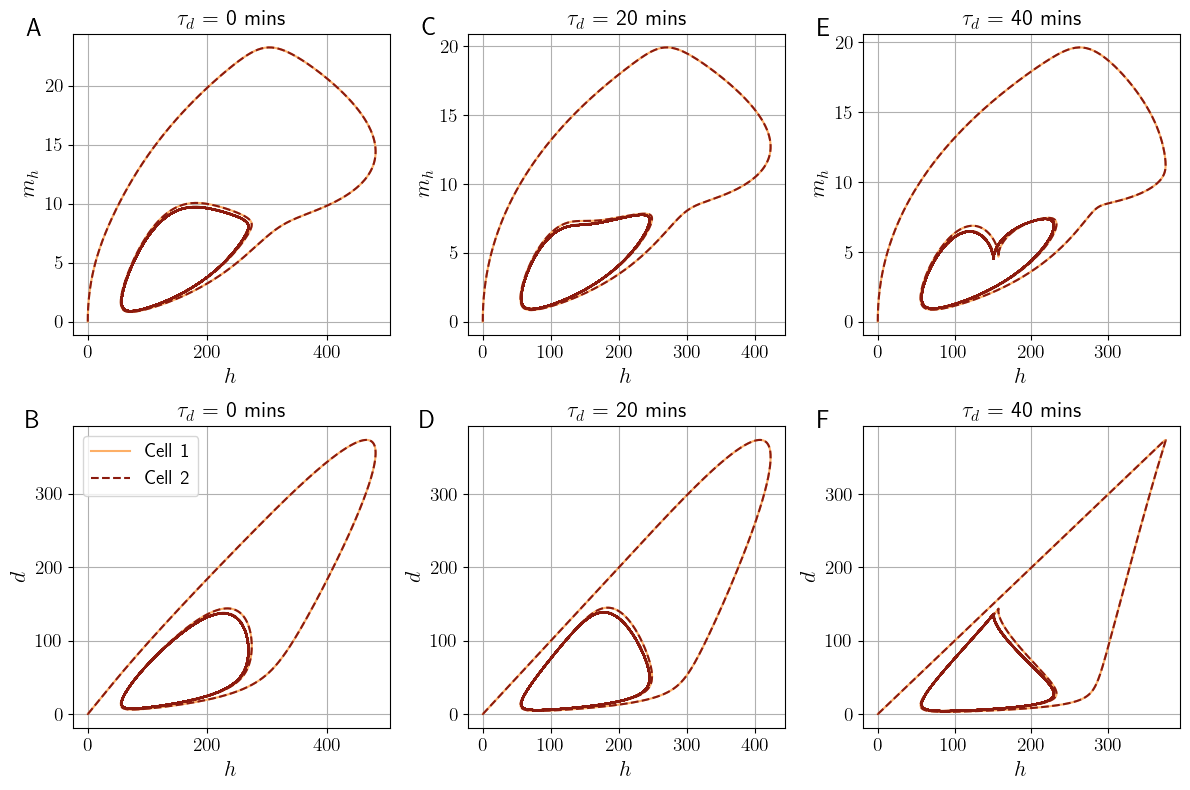

In [39]:
plt.figure(figsize=(12, 8))

# Letters for subplots
letters = ['A', 'B', 'C', 'D', 'E', 'F']
letter_idx = 0

i_strength = 10
for i_delay in [0, 5, 7]:
    
    h_data = results_delay_hes_uniform[i_delay, i_strength, :, 0, :]
    m_h_data = results_delay_hes_uniform[i_delay, i_strength, :, 2, :]
    d_data = results_delay_hes_uniform[i_delay, i_strength, :, 1, :]

    if i_delay == 0:
        i = 1
    elif i_delay == 5:
        i = 2
    elif i_delay == 7:
        i = 3

    ax1 = plt.subplot(2, 3, i)
    ax1.plot(h_data[:, 0], m_h_data[:, 0], label='Cell 1', color=colours[1], ls='-')
    ax1.plot(h_data[:, 1], m_h_data[:, 1], label='Cell 2', color=colours[-1], ls='--')
    ax1.set_xlabel(r'$h$', fontsize=16)
    ax1.set_ylabel(r'$m_h$', fontsize=16)
    ax1.tick_params(labelsize=14)
    ax1.set_title(fr'$\tau_d$ = {delays[i_delay]} mins', fontsize=16)
    ax1.grid()
    ax1.text(-0.1, 1.05, letters[letter_idx], transform=ax1.transAxes,
             fontsize=18, fontweight='bold', va='top', ha='right')
    letter_idx += 1

    ax2 = plt.subplot(2, 3, i + 3)
    ax2.plot(h_data[:, 0], d_data[:, 1], label='Cell 1', color=colours[1], ls='-')
    ax2.plot(h_data[:, 1], d_data[:, 0], label='Cell 2', color=colours[-1], ls='--')
    ax2.set_xlabel(r'$h$', fontsize=16)
    ax2.set_ylabel(r'$d$', fontsize=16)
    ax2.tick_params(labelsize=14)
    ax2.set_title(fr'$\tau_d$ = {delays[i_delay]} mins', fontsize=16)
    ax2.grid()
    ax2.text(-0.1, 1.05, letters[letter_idx], transform=ax2.transAxes,
             fontsize=18, fontweight='bold', va='top', ha='right')
    letter_idx += 1

    if i_delay == 0:
        ax2.legend(fontsize=14)

plt.tight_layout()
# plt.savefig('delay-limit-cycle.png', dpi=600, bbox_inches='tight')


# Influence of initial condition

Calculate Hes difference

In [9]:
# calculate the difference in hes between the two cells for the last 2000
# for coupling strength 0.25
h_diff_25 = np.mean(np.abs(results_25[:,18000:,0,0] - results_25[:,18000:,0,1]), axis=1)
# across an array of coupling strengths
h_diffs = np.mean(np.abs(results_initial_heatmap[:,:,18000:,0,0] - results_initial_heatmap[:,:,18000:,0,1]), axis=2)

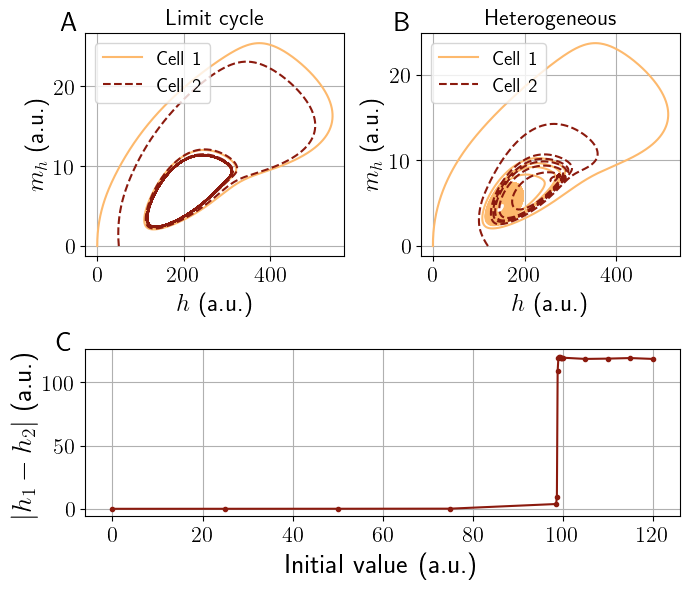

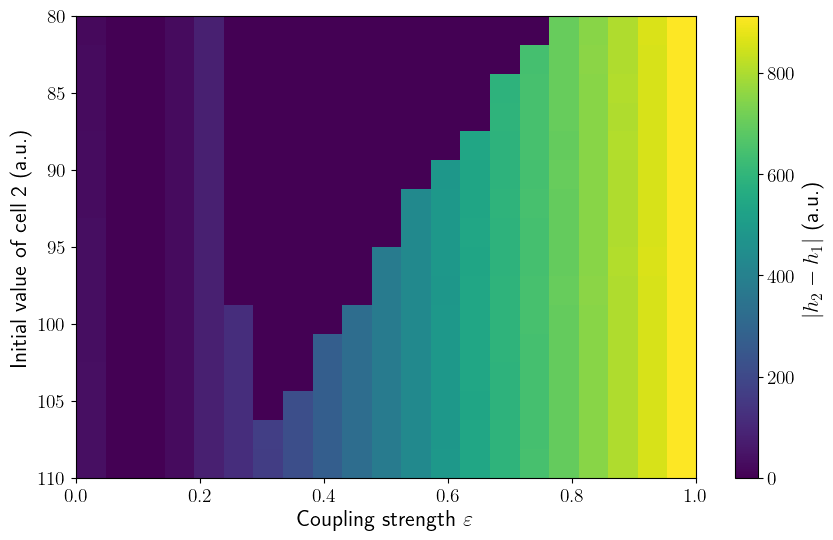

In [13]:
colours = vis.get_hes_colors(len(initial_values))

# Create figure and gridspec:
fig = plt.figure(figsize=(7, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 0.9])

# --------------------------
# Top Left subplot
# --------------------------
ax1 = fig.add_subplot(gs[0, 0])
i = 2
ax1.plot(results_25[i,:,0,0], results_25[i,:,2,0],
         label='Cell 1', color=colours[1], ls='-')
ax1.plot(results_25[i,:,0,1], results_25[i,:,2,1],
         label='Cell 2', color=colours[-1], ls='--')
ax1.set_xlabel(r'$h$ (a.u.)', fontsize=18)
ax1.set_ylabel(r'$m_h$ (a.u.)', fontsize=18)
ax1.set_title(f'Limit cycle', fontsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.grid()
ax1.legend(fontsize=14)


# Add subplot label "A"
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes,
         fontsize=20, fontweight='bold', va='top', ha='left')

# --------------------------
# Top Right subplot
# --------------------------
ax2 = fig.add_subplot(gs[0, 1])
i = -1
ax2.plot(results_25[i,:,0,0], results_25[i,:,2,0],
         label='Cell 1', color=colours[1], ls='-')
ax2.plot(results_25[i,:,0,1], results_25[i,:,2,1],
         label='Cell 2', color=colours[-1], ls='--')
ax2.set_xlabel(r'$h$ (a.u.)', fontsize=18)
ax2.set_ylabel(r'$m_h$ (a.u.)', fontsize=18)
ax2.set_title(f'Heterogeneous', fontsize=16)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.grid()
ax2.legend(fontsize=14)


# Add subplot label "B"
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes,
         fontsize=20, fontweight='bold', va='top', ha='left')

# --------------------------
# Bottom subplot (spanning both columns)
# --------------------------
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(initial_values, h_diff_25,
         label=rf'$\varepsilon$ 0.25',
         color=colours[-1],
         marker='.')
ax3.set_xlabel('Initial value (a.u.)', fontsize=20)
ax3.set_ylabel(r'$|h_1 - h_2|$ (a.u.)', fontsize=20)
ax3.grid()
ax3.tick_params(axis='x', labelsize=16)
ax3.tick_params(axis='y', labelsize=16)
# ax3.legend(fontsize=14)

# Add subplot label "C"
ax3.text(-0.05, 1.1, 'C', transform=ax3.transAxes,
         fontsize=20, fontweight='bold', va='top', ha='left')

plt.tight_layout()
# plt.savefig('two-cell-initial-values.png', dpi=600)
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(h_diffs, aspect='auto', cmap='viridis', extent=[coupling_strength_range[0], coupling_strength_range[-1], initial_values_range[-1], initial_values_range[0]])
cbar = plt.colorbar()
cbar.set_label(' $|h_2 - h_1|$ (a.u.)', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'Coupling strength $\varepsilon$', fontsize=16)
plt.ylabel('Initial value of cell 2 (a.u.)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('two-cell-initial-heatmap.png', dpi=600)